# Chemical data analysis and visualization (part 1)

### Library imports

In [2]:
library(openxlsx)
library(tidyverse)
library(ggbreak)

library(NADA)
library(NADA2)
library(latex2exp)
library(cowplot)

In [3]:
img.path <- "../publication/IMG/"

### 1. Importing the levels of detection and quantification of each parameter from the dataset

This dataframe contains auxiliary information on the chemical parameters measurements:
 - `Column.name` - is a name of the column with the measurements of a considered parameter
 - `Full.name` - is the name given in the original MS Excel file
 - `LOD` - contains the level of detection
 - `LOQ` - contains the level of quantification
 - `Recommendation_low` - denotes the low bound of the recommended level
  - `Recommendation_top` - denotes the top bound of the recommended level; if only this is present it means that the parameter should not exceed this value
  - `comment` - additional information

In [4]:
df.lod <- openxlsx::read.xlsx("data/chemical_data.xlsx",sheet=2)
head(df.lod)

,Column.name,Full.name,Units,LOD,LOQ,Recommendation_low,Recommendation_top,comment
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,pH,pH,[-],0.00,0.00,6.5,8.5,0 means no LOD / LOQ
2,conductivity,conductivity,[uS/cm],0.00,0.00,NA,2000.0,0 means no LOD / LOQ
3,F,F-,[mg/L],0.06,0.18,NA,1.5,NA
4,Cl,Cl-,[mg/L],0.06,0.18,NA,250.0,NA
5,Br,Br-,[mg/L],0.06,0.18,NA,NA,NA
6,NO3,NO3-,[mg/L],0.06,0.18,NA,10.0,NA


### 2. Importing the chemical data
The chemical data is censored: column name `<parameter>.LOQ` denotes the censoring flag (according to level of quantificaion LOQ; set manually).

In [5]:
df <- openxlsx::read.xlsx("data/chemical_data.xlsx",sheet=1)
df["sampling.date"] <- openxlsx::convertToDate(df[["sampling.date"]])
head(df,3)

,sample.name,sampling.date,sampling.site,country,region,district.place,water.source.type,water.source.type.flag,measurement.series,loc.x,⋯,SA,SA.LOQ,SNI,SNI.LOQ,meq.Cl,meq.SO4,meq.Na,meq.K,meq.Cl+SO4,meq.Na+K
,<chr>,<date>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,⋯,<dbl>,<lgl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,MAD_1,2014-12-01,Lake in Tsinjofary,Madagascar,Tsinjofary,NA,lake,MAD1,MAD_A,47.64074,⋯,0.05,TRUE,0.1,TRUE,0.3497884,0.05075466,0.5891257,0.28780051,0.40054309,0.8769262
2,MAD_2,2014-12-01,Lake in Tsararivotra,Madagascar,Tsararivotra,NA,lake,MAD2,MAD_A,47.60931,⋯,0.05,TRUE,0.1,TRUE,0.1184767,0.03060269,0.6078730,0.29485934,0.14907941,0.9027323
3,MAD_3,2014-12-01,Lake in Andilambe,Madagascar,Andilambe,NA,lake,MAD3,MAD_A,47.47847,⋯,0.05,TRUE,0.1,TRUE,0.0448519,0.02058915,0.3886907,0.08611253,0.06544106,0.4748033


In [6]:
str(df)

'data.frame':	29 obs. of  57 variables:
 $ sample.name           : chr  "MAD_1" "MAD_2" "MAD_3" "MAD_4" ...
 $ sampling.date         : Date, format: "2014-12-01" "2014-12-01" ...
 $ sampling.site         : chr  "Lake in Tsinjofary" "Lake in Tsararivotra" "Lake in Andilambe" "Deep well in Andilambe" ...
 $ country               : chr  "Madagascar" "Madagascar" "Madagascar" "Madagascar" ...
 $ region                : chr  "Tsinjofary" "Tsararivotra" "Andilambe" "Andilambe" ...
 $ district.place        : chr  NA NA NA NA ...
 $ water.source.type     : chr  "lake" "lake" "lake" "deep well" ...
 $ water.source.type.flag: chr  "MAD1" "MAD2" "MAD3" "MAD4" ...
 $ measurement.series    : chr  "MAD_A" "MAD_A" "MAD_A" "MAD_A" ...
 $ loc.x                 : num  47.6 47.6 47.5 47.5 47.7 ...
 $ loc.y                 : num  -16 -15.9 -18.8 -18.8 -16.1 ...
 $ pH                    : num  7.72 7.12 7.46 7.19 6.95 7.77 5.44 4.49 5.3 5.38 ...
 $ conductivity          : num  103.5 155.3 77.2 23.5 83.7 ..

Since the data is censored summarization using `summary()` does not make much sense.

In [7]:
# summary(df)

### 3. Displaying information about the measurement campaigns

In [8]:
df %>% group_by(country,measurement.series) %>% summarize(n(),min(sampling.date),max(sampling.date))

`summarise()` has grouped output by 'country'. You can override using the
`.groups` argument.


country,measurement.series,n(),min(sampling.date),max(sampling.date)
<chr>,<chr>,<int>,<date>,<date>
Madagascar,MAD_A,6,2014-12-01,2014-12-04
Madagascar,MAD_B,11,2022-06-27,2022-07-05
Rwanda,RWA,3,2016-08-24,2016-08-27
Uganda,UGA,9,2016-08-14,2016-08-29


#### Sampling campaigns by date and country

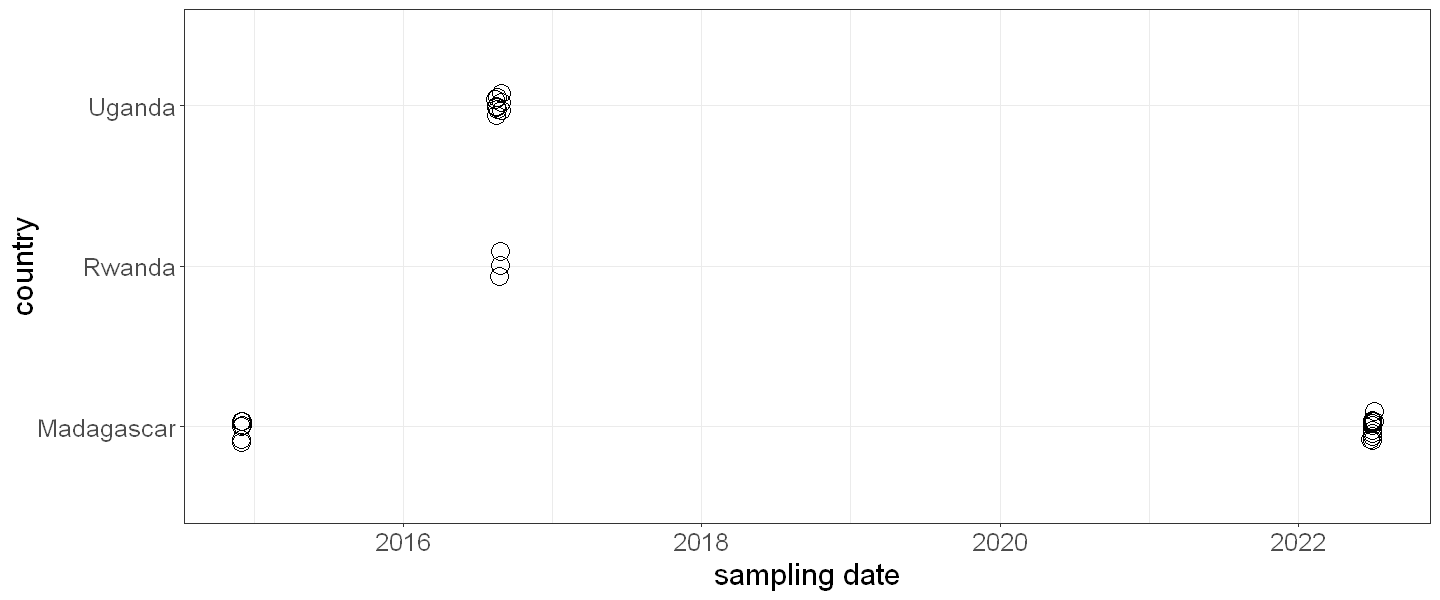

In [9]:
options(repr.plot.width=12,repr.plot.height=5)
ggplot(df,aes(x=sampling.date,y=country)) + geom_jitter(size=5,shape=21,width = 0.01,height = 0.1) +
xlab("sampling date") + ylab("country") + 
theme_bw() +
theme(axis.text = element_text(size=15),
      axis.title = element_text(size=18))

### 4. Determining the relation of each parameter with respect to LOQ / checking the correctness of the LOQ censoring
The following dataframe displays the information on the level of quantification (LOQ) and the number of samples in which this level was not reached (`ls.LOQ`), was equal (`eq.LOQ`) or exceeeded (`gt.LOQ`). Column `flags` displays the amount of censoring flags given (manually) in the MS Excel file. For each row the numbers given in columns `eq.LOQ` and `flags` should be the same. No elements below LOQ should be present. Column `nrows` displays the number of rows in the dataframe, whereas `valid` presents the number of valid observations (not `NA` values).

In [10]:
df.loq.summary <- NULL
for (ix in rev(1:nrow(df.lod))){
    c <- df.lod[ix,"Column.name"]
    loq <- df.lod[ix,"LOQ"]
    less.than.loq <- sum(df[[c]] < loq, na.rm=TRUE)
    equal.to.loq <- sum(df[[c]] == loq, na.rm=TRUE)
    equal.to.loq.flag <- sum(df[[paste0(c,".LOQ")]], na.rm=TRUE)
    gt.than.loq <- sum(df[[c]] > loq, na.rm=TRUE)
    
    tmp.df <- data.frame(parameter=c,LOQ=loq,ls.LOQ=less.than.loq,eq.LOQ=equal.to.loq,flags=equal.to.loq.flag,gt.LOQ=gt.than.loq,nrows=length(df[[c]]),valid=sum(!is.na(df[[c]])))
    if (is.null(df.loq.summary)){
        df.loq.summary <- tmp.df
    } else {
        df.loq.summary <- rbind(tmp.df,df.loq.summary)
    }
}

df.loq.summary

parameter,LOQ,ls.LOQ,eq.LOQ,flags,gt.LOQ,nrows,valid
<chr>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>
pH,0.000,0,0,0,29,29,29
conductivity,0.000,0,0,0,29,29,29
F,0.180,0,15,15,14,29,29
Cl,0.180,0,0,0,29,29,29
Br,0.180,0,26,26,3,29,29
NO3,0.180,0,6,6,23,29,29
NO2,0.270,0,28,28,1,29,29
SO4,0.270,0,0,0,29,29,29
PO4,0.270,0,20,20,9,29,29


##### The following table displays the number of elements which had values below LOQ by country / measurement campaign

In [11]:
tmp.df <- df %>% group_by(country,measurement.series) %>% summarize(F=sum(F.LOQ),Cl=sum(Cl.LOQ),Br=sum(Br.LOQ),NO3=sum(NO3.LOQ),NO2=sum(NO2.LOQ),SO4=sum(SO4.LOQ),PO4=sum(PO4.LOQ),
                                      Li=sum(Li.LOQ),Na=sum(Na.LOQ),K=sum(K.LOQ),NH4=sum(NH4.LOQ),Ca2=sum(Ca2.LOQ),Mg2=sum(Mg2.LOQ),TOC=sum(TOC.LOQ),
                                      Phenols=sum(phenols.LOQ),form=sum(formaldehyde.LOQ,na.rm=TRUE),CS=sum(CS.LOQ),SA=sum(SA.LOQ),SNI=sum(SNI.LOQ))

t(tmp.df)

`summarise()` has grouped output by 'country'. You can override using the
`.groups` argument.


country,Madagascar,Madagascar,Rwanda,Uganda
measurement.series,MAD_A,MAD_B,RWA,UGA
F,1,11,0,3
Cl,0,0,0,0
Br,5,9,3,9
NO3,3,1,0,2
NO2,6,11,2,9
SO4,0,0,0,0
PO4,1,11,3,5
Li,6,11,0,0
Na,0,0,0,1


### 5. Handling censored data
For censored data NADA and NADA2 packages can be considered. However the dataset is very sparse, and summarizing data in such way can be considered improper. Here only example plots are given. Finally we decided to display every point separately.

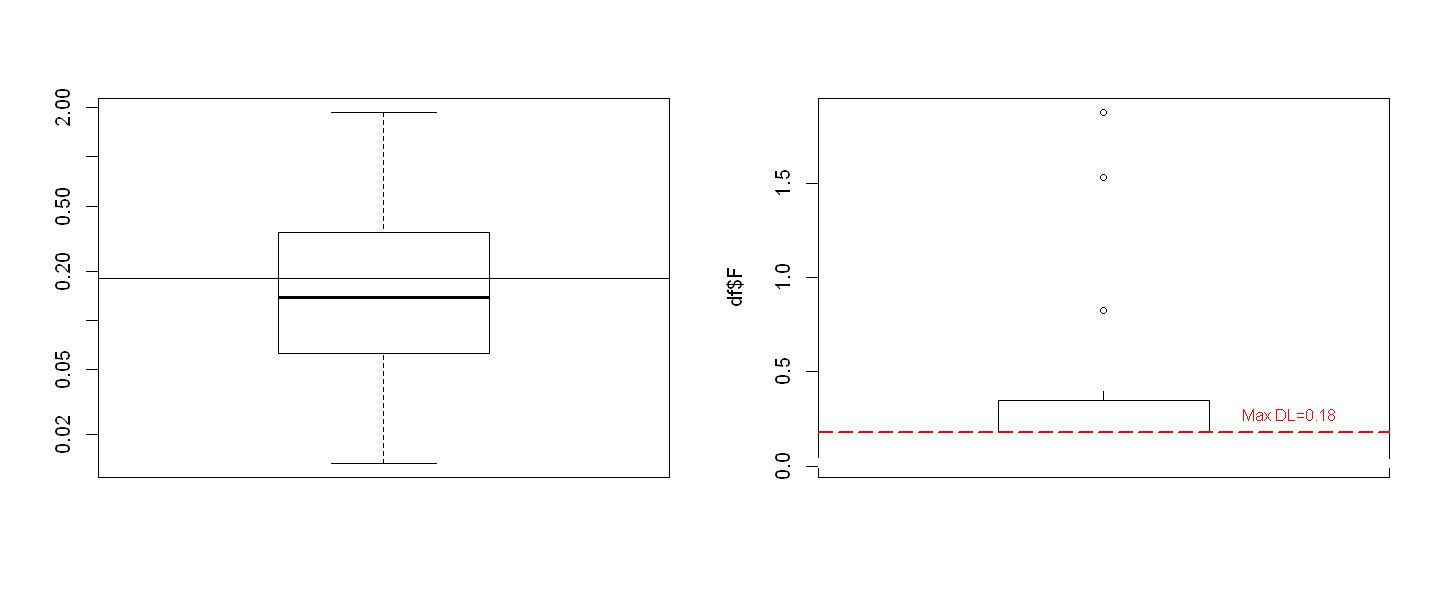

In [12]:
par(mfrow = c(1, 2))
NADA::cenboxplot(df$F,df$F.LOQ,log=TRUE)
NADA2::cboxplot(df$F,df$F.LOQ)

Warning message in NADA2::cboxplot(df[feat], df[paste0(feat, ".LOQ")], xgroup = df$measurement.series):
"Note: One group had fewer than 3 detects and so cannot be plotted."


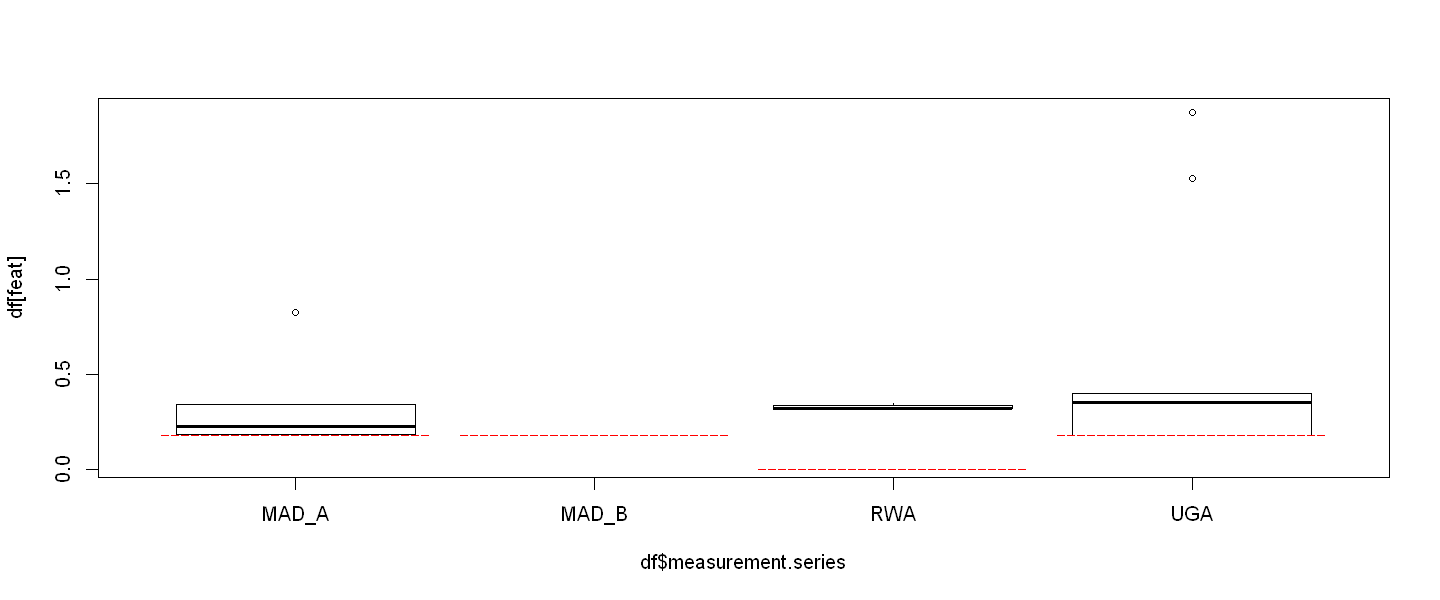

In [13]:
feat <- "F"
NADA2::cboxplot(df[feat],df[paste0(feat,".LOQ")],xgroup=df$measurement.series)

In [14]:
censtats(df$F,df$F.LOQ)

       n    n.cen  pct.cen 
29.00000 15.00000 51.72414 


,median,mean,sd
,<dbl>,<dbl>,<dbl>
K-M,NA,0.3574828,0.4045149
ROS,0.1383978,0.2953008,0.4286017
MLE,0.1679586,0.3024983,0.4531124


### 6. Analysis of the water source type

In [15]:
df %>% group_by(country,measurement.series,water.source.type) %>% summarize(n())

`summarise()` has grouped output by 'country', 'measurement.series'. You can
override using the `.groups` argument.


country,measurement.series,water.source.type,n()
<chr>,<chr>,<chr>,<int>
Madagascar,MAD_A,deep well,2
Madagascar,MAD_A,lake,3
Madagascar,MAD_A,river,1
Madagascar,MAD_B,deep well,8
Madagascar,MAD_B,tap water,3
Rwanda,RWA,spring,1
Rwanda,RWA,tap water,2
Uganda,UGA,deep well,2
Uganda,UGA,lake,2


In [16]:
tbl.ws.type <- table(df[c("measurement.series","water.source.type")])
tbl.ws.type

                  water.source.type
measurement.series deep well lake rain water river spring tap water
             MAD_A         2    3          0     1      0         0
             MAD_B         8    0          0     0      0         3
             RWA           0    0          0     0      1         2
             UGA           2    2          1     1      1         2

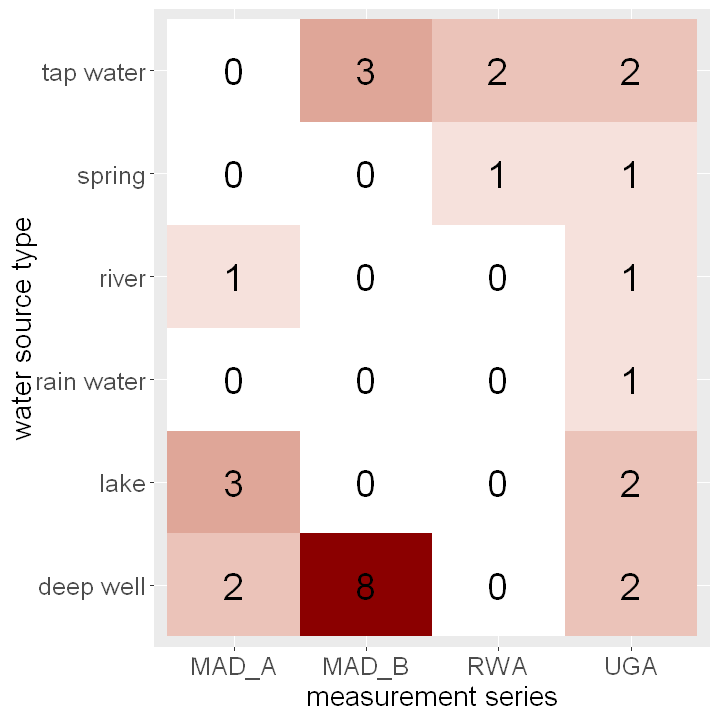

In [17]:
options(repr.plot.width=6,repr.plot.height=6)

df.ws.type <- data.frame(tbl.ws.type)

p <- ggplot(df.ws.type,aes(x=measurement.series,y=water.source.type,fill=Freq)) + 
geom_tile() + geom_text(aes(label=Freq),size=8) + 
scale_fill_gradient(low="white",high="darkred") + 
xlab("measurement series") + ylab("water source type") +
theme(axis.text=element_text(size=15),
      axis.title=element_text(size=17),
      legend.position="none")
p
#ggsave("IMG/counts.tiff",p,width=6,height=6,dpi=300)

### 7. Plots displaying the particular parameters with respect to measurement campaign and water source type

#### 7.1. pH and conductivity

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message:
"The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead."


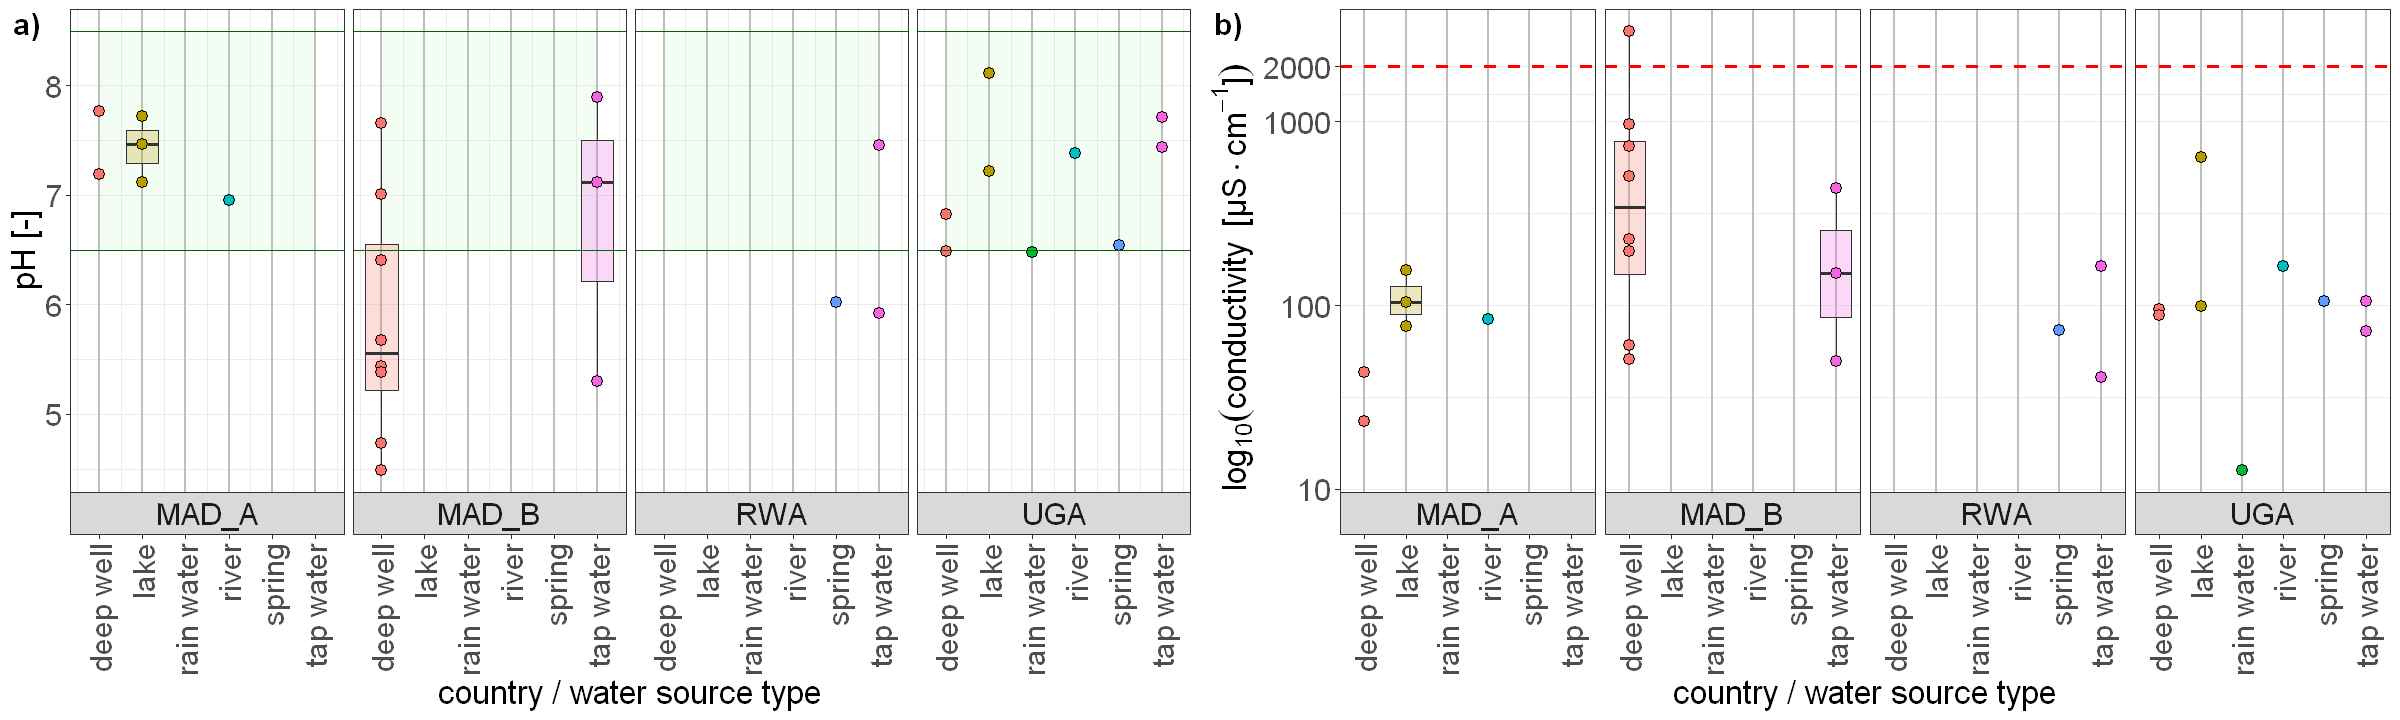

In [18]:
options(repr.plot.height=6,repr.plot.width=20)

feat <- "pH"
feat.rec.top <- df.lod$Recommendation_top[df.lod$Column.name==feat]
feat.rec.low <- df.lod$Recommendation_low[df.lod$Column.name==feat]

tmp.df <- df[c(feat,"water.source.type","measurement.series")]
tmp.df$feat.rec.low <-feat.rec.low
tmp.df$feat.rec.top <-feat.rec.top
tmp.df$water.source.factor <- factor(tmp.df$water.source.type)


df.poly <- rbind(data.frame(x=c(1,6,6,1),y=c(tmp.df$feat.rec.low,tmp.df$feat.rec.low,tmp.df$feat.rec.top,tmp.df$feat.rec.top),measurement.series="MAD_A"),
                 data.frame(x=c(1,6,6,1),y=c(tmp.df$feat.rec.low,tmp.df$feat.rec.low,tmp.df$feat.rec.top,tmp.df$feat.rec.top),measurement.series="MAD_B"),
                 data.frame(x=c(1,6,6,1),y=c(tmp.df$feat.rec.low,tmp.df$feat.rec.low,tmp.df$feat.rec.top,tmp.df$feat.rec.top),measurement.series="RWA"),
                 data.frame(x=c(1,6,6,1),y=c(tmp.df$feat.rec.low,tmp.df$feat.rec.low,tmp.df$feat.rec.top,tmp.df$feat.rec.top),measurement.series="UGA"))

p1<- ggplot() +  
geom_polygon(data=df.poly,aes(x=x, y=y),fill="lightgreen",alpha=0.1) +
geom_boxplot(data=(tmp.df %>% group_by(measurement.series,water.source.type) %>% filter(n() >=3)),aes(x=as.numeric(water.source.factor),y=pH,fill=water.source.type),alpha=0.25) + 
geom_point(data=tmp.df,aes(x=as.numeric(water.source.factor),y=pH,fill=water.source.type),size=3,shape=21) + 
facet_wrap(~measurement.series,ncol=4,drop=TRUE,strip.position = "bottom") + 
geom_hline(yintercept = feat.rec.low,color="darkgreen",linewidth=0.5,linetype="solid") +
geom_hline(yintercept = feat.rec.top,color="darkgreen",linewidth=0.5,linetype="solid") +
xlab("country / water source type") + ylab(paste(feat,"[-]"))+ scale_x_continuous(breaks=1:6, labels=levels(tmp.df$water.source.factor)) +
theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1,size=18),
                   axis.text.y = element_text(size=18),
                   strip.text = element_text(size=18),
                   axis.title = element_text(size=20),
                   legend.position = "none",
                  # panel.grid.minor.y = element_blank(),
                   panel.grid.major.x = element_line(color = "gray",linewidth = .75))  



feat <- "conductivity"
feat.loq <- df.lod$LOQ[df.lod$Column.name==feat]
feat.rec <- df.lod$Recommendation_top[df.lod$Column.name==feat]

p2 <- ggplot(df,aes(x=water.source.type,y=conductivity,fill=water.source.type)) +
geom_boxplot(data=(df %>% group_by(measurement.series,water.source.type) %>% filter(n() >=3)),alpha=0.25) + 
geom_point(size=3,shape=21) + 
#geom_hline(yintercept = feat.loq,color="gray",linewidth=1) + # no LOD
geom_hline(yintercept = feat.rec,color="red",linewidth=1,linetype="dashed") + 
#scale_y_break(breaks=c(3500,24990),scales=c(0.05,2),ticklabels=c( 2000)) + 
ylim(0,2100)+
scale_shape_manual(values=c(21, 24))+
facet_wrap(~measurement.series,ncol=4,drop=TRUE,strip.position = "bottom") + 
xlab("country / water source type") + ylab(TeX("$log_{10}(conductivity \\phantom{x}[μS \\cdot cm^{-1}])$      "))+ scale_y_continuous(trans='log10',breaks=c(10, 100, 1000,2000))+
theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1,size=18),
                   axis.text.y = element_text(size=18),
                   strip.text = element_text(size=18),
                   axis.title = element_text(size=20),
                   legend.position = "none",
                  # panel.grid.minor.y = element_blank(),
                   panel.grid.major.x = element_line(color = "gray",size = .75),
                   # removing additional y axis
                   axis.text.y.right = element_blank(),        
                   axis.line.y.right = element_blank(),
                   axis.ticks.y.right = element_blank()) 


plot_grid(p1,p2,ncol=2,labels=c("a)","b)"),label_size=18)

#ggsave(paste0(img.path,"conductivity_pH.tiff"),width=18,height=6,dpi=600)
#ggsave(paste0(img.path,"conductivity_pH.png"),width=18,height=6,dpi=150)

#### 7.2. CS

Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_hline()`)."


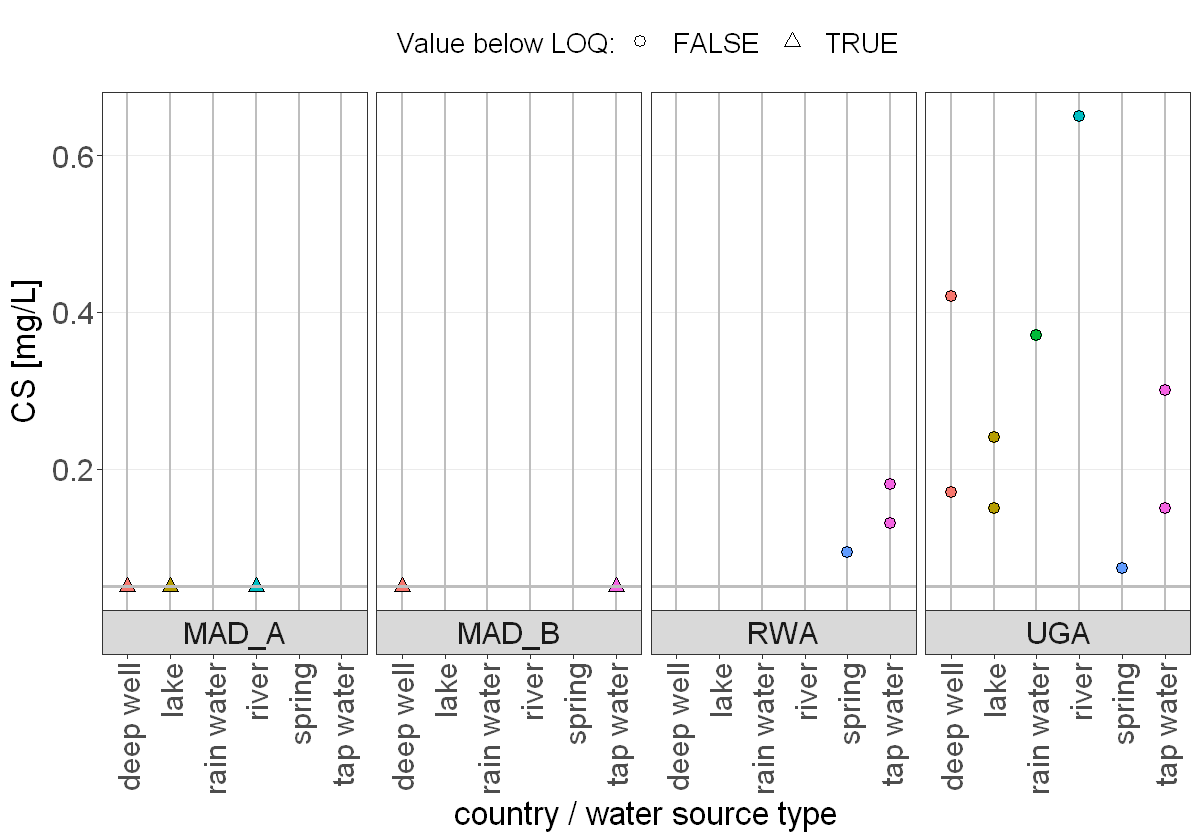

In [19]:
options(repr.plot.height=7,repr.plot.width=10)

feat <- "CS"
feat.loq <- df.lod$LOQ[df.lod$Column.name==feat]
feat.rec <- df.lod$Recommendation_top[df.lod$Column.name==feat]

p.CS <- ggplot(df,aes(x=water.source.type,y=get(feat),fill=water.source.type)) + 
geom_point(size=3,aes(shape=get(paste0(feat,".LOQ")))) + 
geom_hline(yintercept = feat.loq,color="gray",linewidth=1) + 
geom_hline(yintercept = feat.rec,color="red",linewidth=1,linetype="dashed") + 

#scale_y_break(breaks=c(100,198),scales=c(0.1,2),ticklabels=c(200)) + ylim(0,201)+

scale_shape_manual(values=c(21, 24),name="Value below LOQ:")+
facet_wrap(~measurement.series,ncol=4,drop=TRUE,strip.position = "bottom") + 
xlab("country / water source type") + ylab(TeX("$CS$ [mg/L]"))+ 
guides(shape = "legend",colour="none",size="none",fill="none")+
theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1,size=18),
                   axis.text.y = element_text(size=18),
                   strip.text = element_text(size=18),
                   axis.title = element_text(size=20),
                   panel.grid.minor.y = element_blank(),
                   panel.grid.major.x = element_line(color = "gray",size = .75),
                   legend.position="top",
                   legend.key.size = unit(2, 'cm'), #change legend key size
                   legend.key.height = unit(1, 'cm'), #change legend key height
                   legend.key.width = unit(1, 'cm'), #change legend key width
                   legend.title = element_text(size=16), #change legend title font size
                   legend.text = element_text(size=16)) 

#ggsave(paste0(img.path,"CS.tiff"),p.CS,width=10,height=7,dpi=300)
#ggsave(paste0(img.path,"CS.svg"),p.CS,width=10,height=7,dpi=300)
p.CS

#### 7.3. SNI

Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_hline()`)."


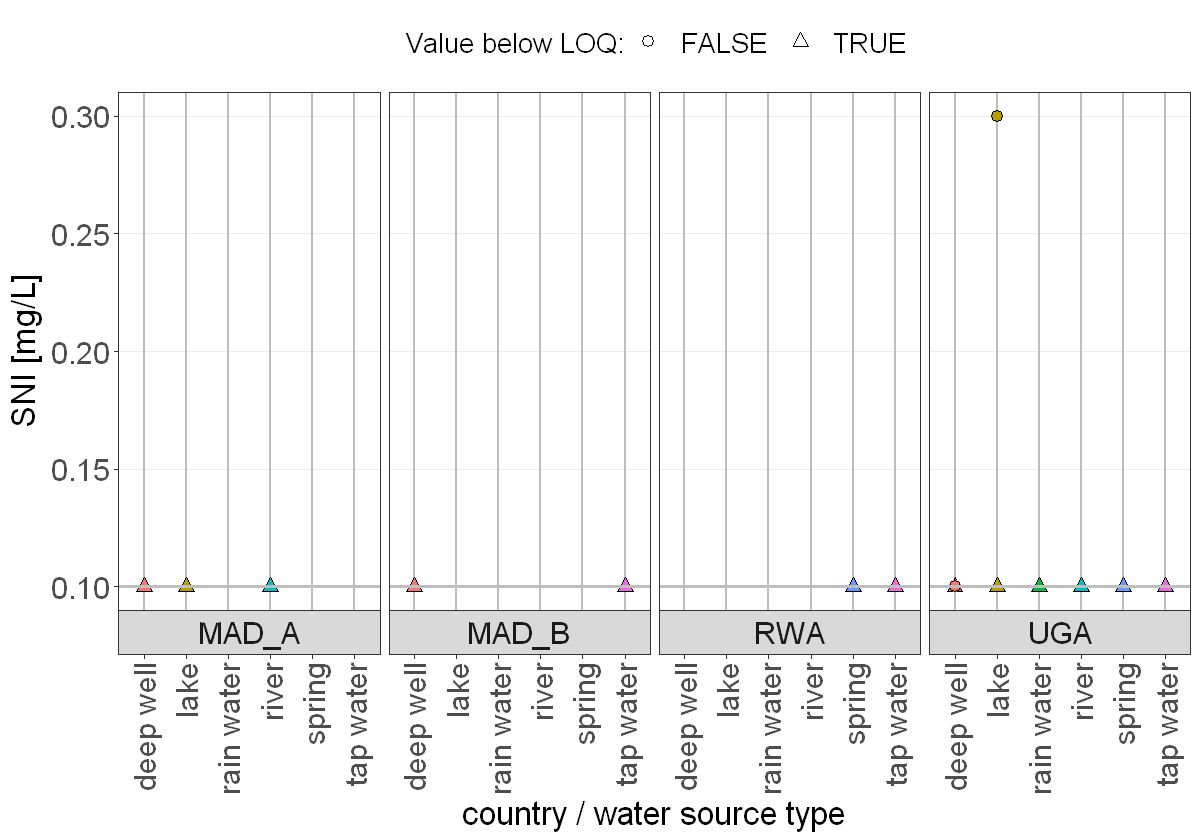

In [20]:
feat <- "SNI"
feat.loq <- df.lod$LOQ[df.lod$Column.name==feat]
feat.rec <- df.lod$Recommendation_top[df.lod$Column.name==feat]

p.SNI <- ggplot(df,aes(x=water.source.type,y=get(feat),fill=water.source.type)) + 
geom_point(size=3,aes(shape=get(paste0(feat,".LOQ")))) + 
geom_hline(yintercept = feat.loq,color="gray",linewidth=1) + 
geom_hline(yintercept = feat.rec,color="red",linewidth=1,linetype="dashed") + 

#scale_y_break(breaks=c(100,198),scales=c(0.1,2),ticklabels=c(200)) + ylim(0,201)+

scale_shape_manual(values=c(21, 24),name="Value below LOQ:")+
facet_wrap(~measurement.series,ncol=4,drop=TRUE,strip.position = "bottom") + 
xlab("country / water source type") + ylab(TeX("$SNI$ [mg/L]"))+ 
guides(shape = "legend",colour="none",size="none",fill="none")+
theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1,size=18),
                   axis.text.y = element_text(size=18),
                   strip.text = element_text(size=18),
                   axis.title = element_text(size=20),
                   panel.grid.minor.y = element_blank(),
                   panel.grid.major.x = element_line(color = "gray",size = .75),
                   legend.position="top",
                   legend.key.size = unit(2, 'cm'), #change legend key size
                   legend.key.height = unit(1, 'cm'), #change legend key height
                   legend.key.width = unit(1, 'cm'), #change legend key width
                    legend.title = element_text(size=16), #change legend title font size
                   legend.text = element_text(size=16)) 

#ggsave(paste0(img.path,"SNI.tiff"),p.SNI,width=10,height=7,dpi=300)
#ggsave(paste0(img.path,"SNI.svg"),p.SNI,width=10,height=7,dpi=300)
p.SNI

#### 7.4. SA

Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_hline()`)."


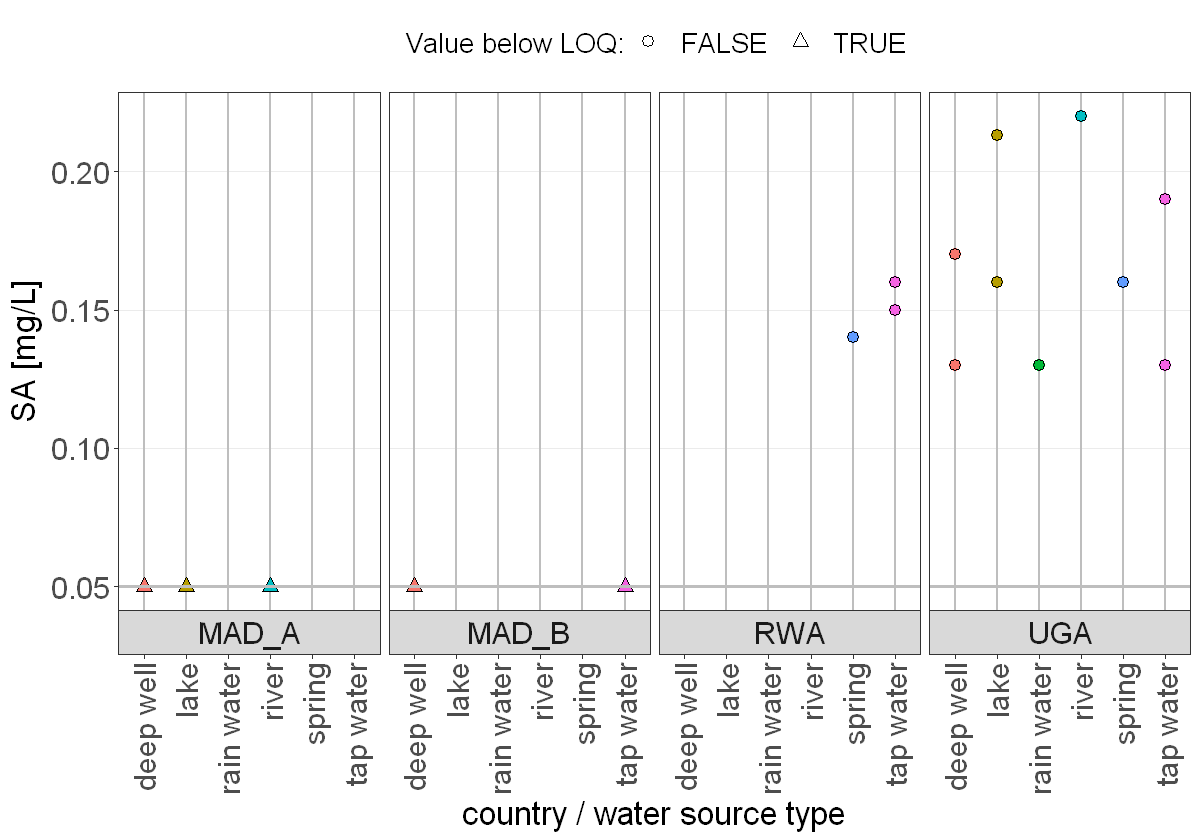

In [21]:
options(repr.plot.height=7,repr.plot.width=10)

feat <- "SA"
feat.loq <- df.lod$LOQ[df.lod$Column.name==feat]
feat.rec <- df.lod$Recommendation_top[df.lod$Column.name==feat]

p.SA <- ggplot(df,aes(x=water.source.type,y=get(feat),fill=water.source.type)) + 
geom_point(size=3,aes(shape=get(paste0(feat,".LOQ")))) + 
geom_hline(yintercept = feat.loq,color="gray",linewidth=1) + 
geom_hline(yintercept = feat.rec,color="red",linewidth=1,linetype="dashed") + 

#scale_y_break(breaks=c(100,198),scales=c(0.1,2),ticklabels=c(200)) + ylim(0,201)+

scale_shape_manual(values=c(21, 24),name="Value below LOQ:")+
facet_wrap(~measurement.series,ncol=4,drop=TRUE,strip.position = "bottom") + 
xlab("country / water source type") + ylab(TeX("$SA$ [mg/L]"))+ 
guides(shape = "legend",colour="none",size="none",fill="none")+
theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1,size=18),
                   axis.text.y = element_text(size=18),
                   strip.text = element_text(size=18),
                   axis.title = element_text(size=20),
                   panel.grid.minor.y = element_blank(),
                   panel.grid.major.x = element_line(color = "gray",size = .75),
                   legend.position="top",
                   legend.key.size = unit(2, 'cm'), #change legend key size
                   legend.key.height = unit(1, 'cm'), #change legend key height
                   legend.key.width = unit(1, 'cm'), #change legend key width
                    legend.title = element_text(size=16), #change legend title font size
                   legend.text = element_text(size=16)) 


#ggsave(paste0(img.path,"SA.tiff"),p.SA,width=10,height=7,dpi=300)
#ggsave(paste0(img.path,"SA.svg"),p.SA,width=10,height=7,dpi=300)
p.SA

#### 7.5. Sum of phenols

Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_hline()`)."


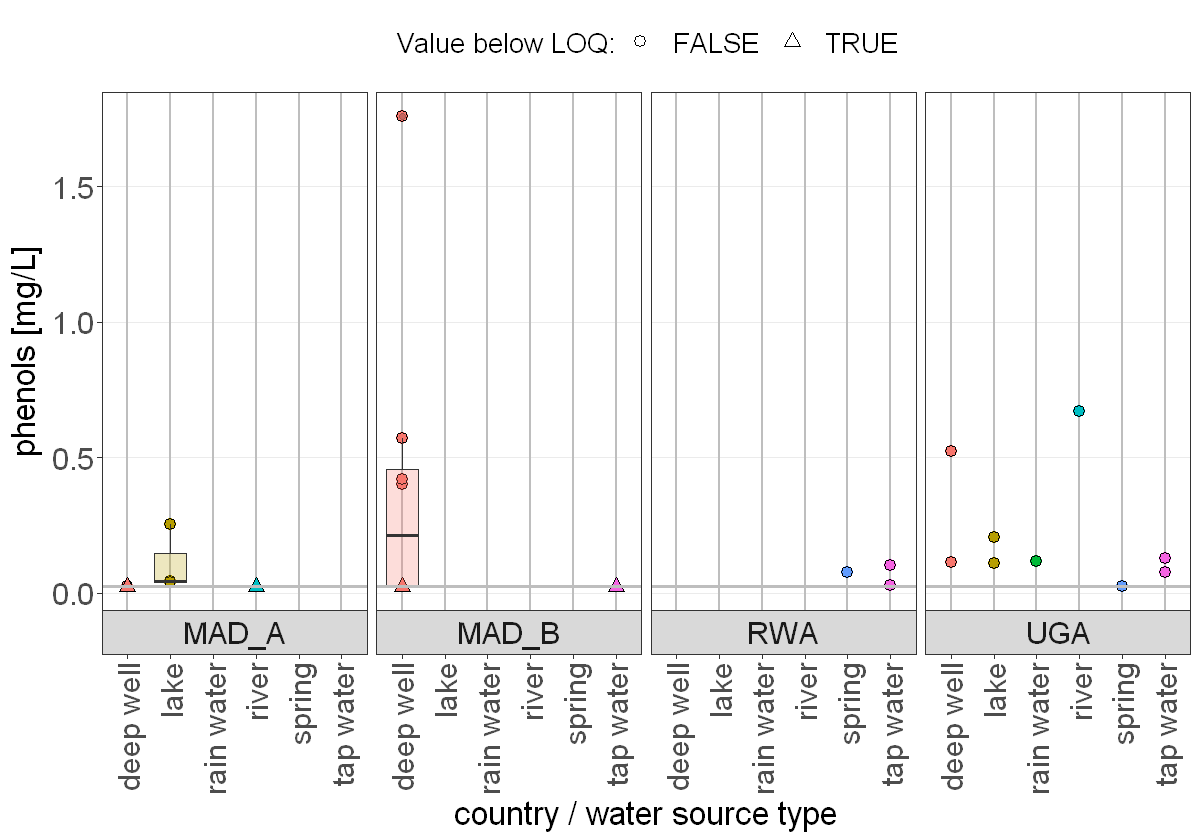

In [22]:
options(repr.plot.height=7,repr.plot.width=10)

feat <- "phenols"
feat.loq <- df.lod$LOQ[df.lod$Column.name==feat]
feat.rec <- df.lod$Recommendation_top[df.lod$Column.name==feat]

p.phenols <- ggplot(df,aes(x=water.source.type,y=get(feat),fill=water.source.type)) + 
geom_point(size=3,aes(shape=get(paste0(feat,".LOQ")))) + geom_boxplot(data=(df %>% group_by(measurement.series,water.source.type) %>% filter(n() >=3)),alpha=0.25) + 
geom_hline(yintercept = feat.loq,color="gray",linewidth=1) + 
geom_hline(yintercept = feat.rec,color="red",linewidth=1,linetype="dashed") + 

#scale_y_break(breaks=c(100,198),scales=c(0.1,2),ticklabels=c(200)) + ylim(0,201)+

scale_shape_manual(values=c(21, 24),name="Value below LOQ:")+
facet_wrap(~measurement.series,ncol=4,drop=TRUE,strip.position = "bottom") + 
xlab("country / water source type") + ylab(TeX("$phenols$ [mg/L]"))+ 
guides(shape = "legend",colour="none",size="none",fill="none")+
theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1,size=18),
                   axis.text.y = element_text(size=18),
                   strip.text = element_text(size=18),
                   axis.title = element_text(size=20),
                   panel.grid.minor.y = element_blank(),
                   panel.grid.major.x = element_line(color = "gray",size = .75),
                   legend.position="top",
                   legend.key.size = unit(2, 'cm'), #change legend key size
                   legend.key.height = unit(1, 'cm'), #change legend key height
                   legend.key.width = unit(1, 'cm'), #change legend key width
                    legend.title = element_text(size=16), #change legend title font size
                   legend.text = element_text(size=16)) 

#ggsave(paste0(img.path,"phenols.tiff"),p.phenols,width=10,height=7,dpi=300)
#ggsave(paste0(img.path,"phenols.svg"),p.phenols,width=10,height=7,dpi=300)
p.phenols

#### 7.6. Formaldehyde

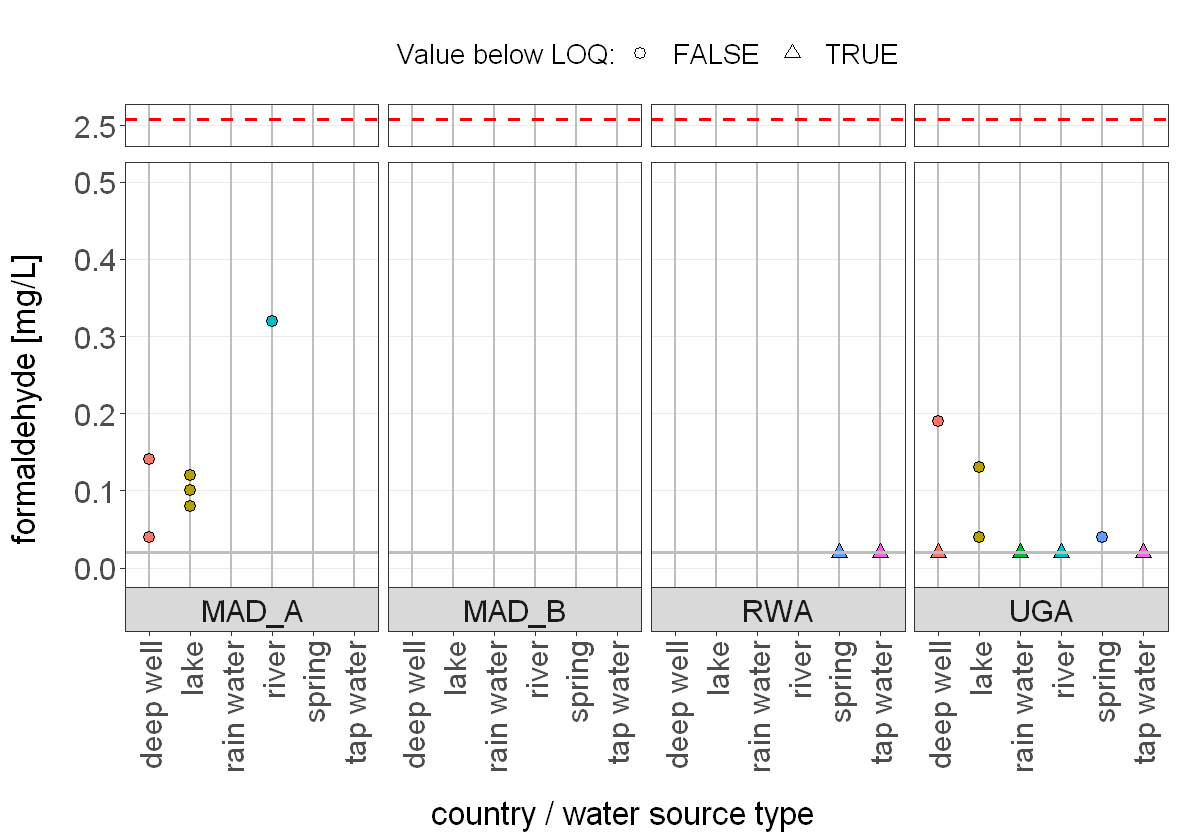

In [23]:
options(repr.plot.height=7,repr.plot.width=10)

feat <- "formaldehyde"
feat.loq <- df.lod$LOQ[df.lod$Column.name==feat]
feat.rec <- df.lod$Recommendation_top[df.lod$Column.name==feat]

p.formaldehyde <- ggplot(df,aes(x=water.source.type,y=get(feat),fill=water.source.type)) + 
geom_point(size=3,aes(shape=get(paste0(feat,".LOQ")))) + 
geom_hline(yintercept = feat.loq,color="gray",linewidth=1) + 
geom_hline(yintercept = feat.rec,color="red",linewidth=1,linetype="dashed") + 

scale_y_break(breaks=c(0.5,2.2),scales=c(0.1,2),ticklabels=c(2.5)) + ylim(0,2.8)+

scale_shape_manual(values=c(21, 24),name="Value below LOQ:",na.translate = F)+
facet_wrap(~measurement.series,ncol=4,drop=TRUE,strip.position = "bottom") + 
xlab("country / water source type") + ylab(TeX("$formaldehyde$ [mg/L]"))+ 
guides(shape = "legend",colour="none",size="none",fill="none")+
theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1,size=18),
                   axis.text.y = element_text(size=18),
                   strip.text = element_text(size=18),
                   axis.title = element_text(size=20),
                   panel.grid.minor.y = element_blank(),
                   panel.grid.major.x = element_line(color = "gray",size = .75),
                   legend.position="top",
                   legend.key.size = unit(2, 'cm'), #change legend key size
                   legend.key.height = unit(1, 'cm'), #change legend key height
                   legend.key.width = unit(1, 'cm'), #change legend key width
                   legend.title = element_text(size=16), #change legend title font size
                   legend.text = element_text(size=16),
                   # removing additional y axis
                   axis.text.y.right = element_blank(),        
                   axis.line.y.right = element_blank(),
                   axis.ticks.y.right = element_blank()) 

#ggsave(paste0(img.path,"formaldehyde.tiff"),p.formaldehyde,width=10,height=7,dpi=300)
#ggsave(paste0(img.path,"formaldehyde.svg"),p.formaldehyde,width=10,height=7,dpi=300)
p.formaldehyde

#### 7.7. TOC

Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_hline()`)."


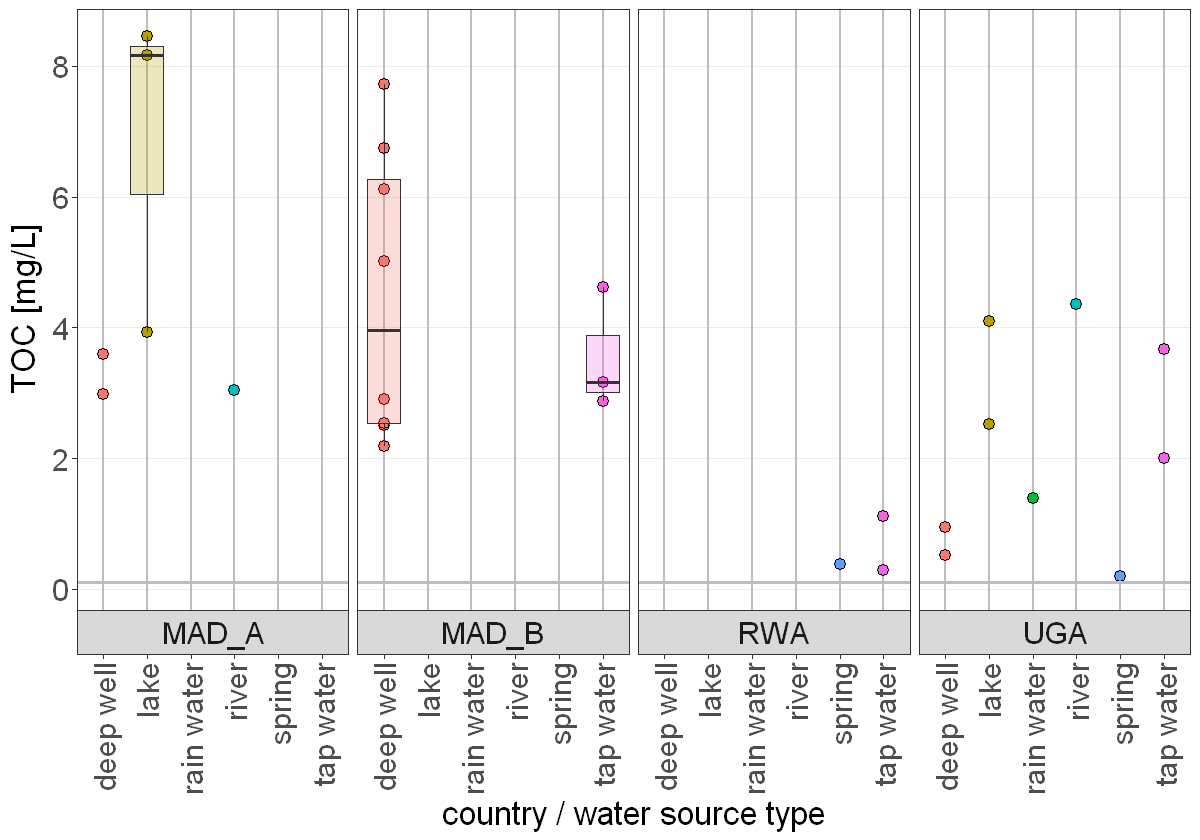

In [24]:
options(repr.plot.height=7,repr.plot.width=10)

feat <- "TOC"
feat.loq <- df.lod$LOQ[df.lod$Column.name==feat]
feat.rec <- df.lod$Recommendation_top[df.lod$Column.name==feat]

p.toc <- ggplot(df,aes(x=water.source.type,y=get(feat),fill=water.source.type)) + 
geom_point(size=3,aes(shape=get(paste0(feat,".LOQ")))) + 
geom_boxplot(data=(df %>% group_by(measurement.series,water.source.type) %>% filter(n() >=3)),alpha=0.25) + 
geom_hline(yintercept = feat.loq,color="gray",linewidth=1) + 
geom_hline(yintercept = feat.rec,color="red",linewidth=1,linetype="dashed") + 

#scale_y_break(breaks=c(100,198),scales=c(0.1,2),ticklabels=c(200)) + ylim(0,201)+

scale_shape_manual(values=c(21, 24),name="Value below LOQ:")+
facet_wrap(~measurement.series,ncol=4,drop=TRUE,strip.position = "bottom") + 
xlab("country / water source type") + ylab(TeX("$TOC$ [mg/L]"))+ 
guides(shape = "legend",colour="none",size="none",fill="none")+
theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1,size=18),
                   axis.text.y = element_text(size=18),
                   strip.text = element_text(size=18),
                   axis.title = element_text(size=20),
                   panel.grid.minor.y = element_blank(),
                   panel.grid.major.x = element_line(color = "gray",size = .75),
                   legend.position="none",
                   legend.key.size = unit(2, 'cm'), #change legend key size
                   legend.key.height = unit(1, 'cm'), #change legend key height
                   legend.key.width = unit(1, 'cm'), #change legend key width
                    legend.title = element_text(size=16), #change legend title font size
                   legend.text = element_text(size=16)) 

#ggsave(paste0(img.path,"TOC.tiff"),p.toc,width=10,height=6,dpi=300)
#ggsave(paste0(img.path,"TOC.svg"),p.toc,width=10,height=6,dpi=300)
p.toc

#### 7.8. $F^-$

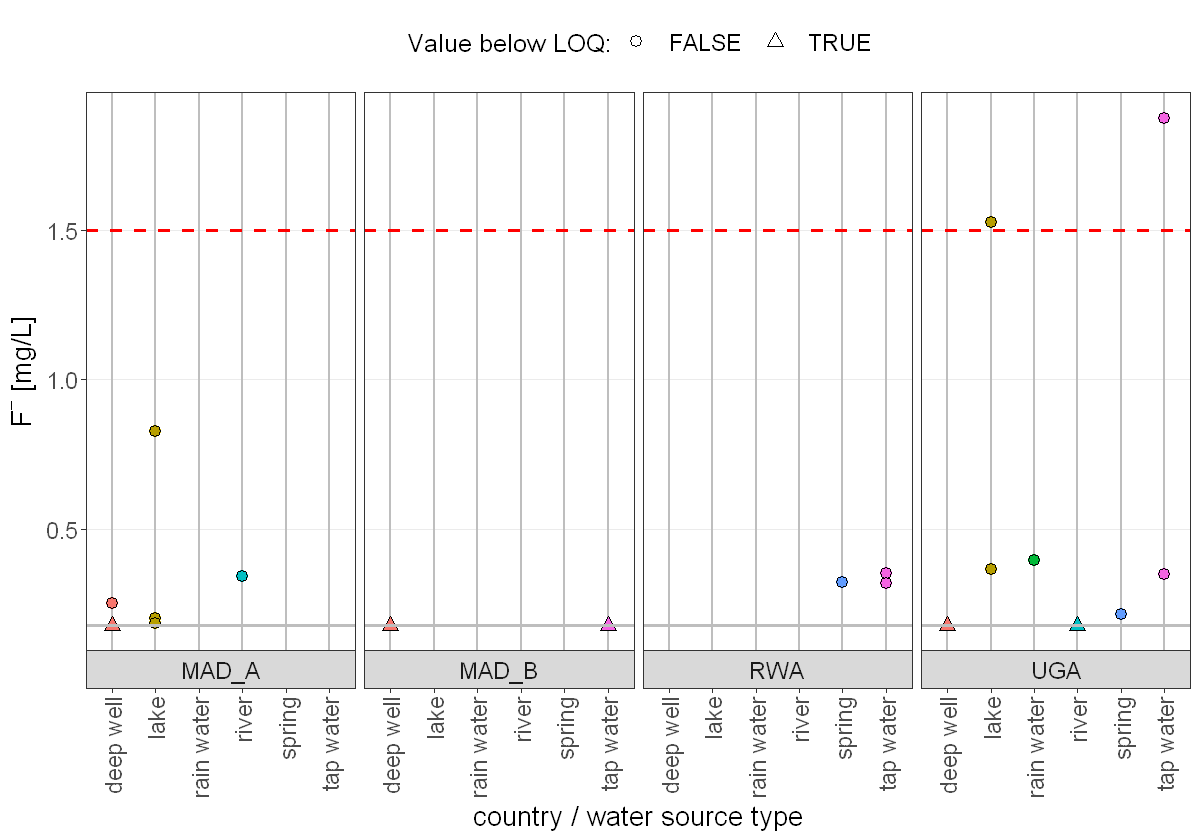

In [25]:
options(repr.plot.height=7,repr.plot.width=10)

feat <- "F"
feat.loq <- df.lod$LOQ[df.lod$Column.name==feat]
feat.rec <- df.lod$Recommendation_top[df.lod$Column.name==feat]

p <- ggplot(df,aes(x=water.source.type,y=get(feat),fill=water.source.type)) + 
geom_point(size=3,aes(shape=get(paste0(feat,".LOQ")))) + 
geom_hline(yintercept = feat.loq,color="gray",linewidth=1) + 
geom_hline(yintercept = feat.rec,color="red",linewidth=1,linetype="dashed") + 
#scale_y_break(breaks=c(100,198),scales=c(0.1,2),ticklabels=c(200)) + ylim(0,201)+
scale_shape_manual(values=c(21, 24),name="Value below LOQ:")+
facet_wrap(~measurement.series,ncol=4,drop=TRUE,strip.position = "bottom") + 
xlab("country / water source type") + ylab(TeX("$F^-$ [mg/L]"))+ 
guides(shape = "legend",colour="none",size="none",fill="none")+
theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1,size=14),
                   axis.text.y = element_text(size=14),
                   strip.text = element_text(size=14),
                   axis.title = element_text(size=16),
                   panel.grid.minor.y = element_blank(),
                   panel.grid.major.x = element_line(color = "gray",size = .75),
                   legend.position="top",
                   legend.key.size = unit(2, 'cm'), #change legend key size
                   legend.key.height = unit(1, 'cm'), #change legend key height
                   legend.key.width = unit(1, 'cm'), #change legend key width
                    legend.title = element_text(size=15), #change legend title font size
                   legend.text = element_text(size=14)) 

#ggsave("IMG/F.tiff",p,width=10,height=7,dpi=300)
p

#### 7.9. $Cl^-$

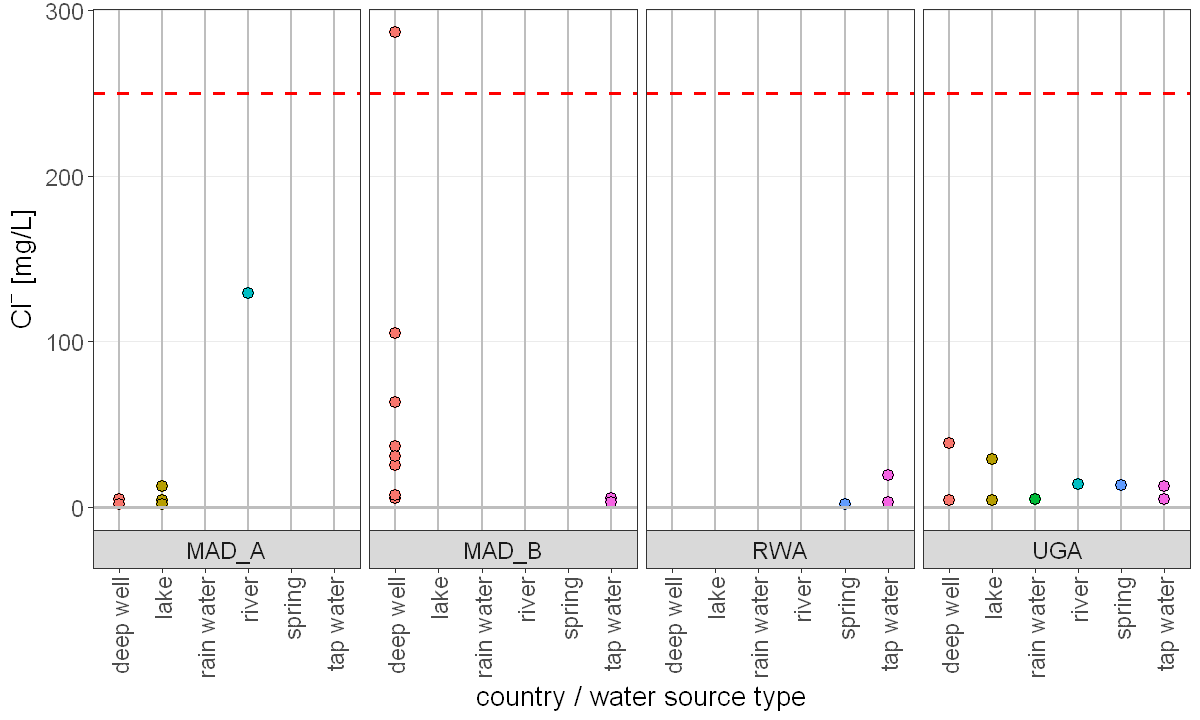

In [26]:
options(repr.plot.height=6,repr.plot.width=10)

feat <- "Cl"
feat.loq <- df.lod$LOQ[df.lod$Column.name==feat]
feat.rec <- df.lod$Recommendation_top[df.lod$Column.name==feat]

p <- ggplot(df,aes(x=water.source.type,y=get(feat),fill=water.source.type)) + 
geom_point(size=3,aes(shape=get(paste0(feat,".LOQ")))) + 
geom_hline(yintercept = feat.loq,color="gray",linewidth=1) + 
geom_hline(yintercept = feat.rec,color="red",linewidth=1,linetype="dashed") + 
#scale_y_break(breaks=c(100,198),scales=c(0.1,2),ticklabels=c(200)) + ylim(0,201)+
scale_shape_manual(values=c(21, 24),name="Value below LOQ:")+
facet_wrap(~measurement.series,ncol=4,drop=TRUE,strip.position = "bottom") + 
xlab("country / water source type") + ylab(TeX("$Cl^-$ [mg/L]"))+ 
guides(shape = "legend",colour="none",size="none",fill="none")+
theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1,size=14),
                   axis.text.y = element_text(size=14),
                   strip.text = element_text(size=14),
                   axis.title = element_text(size=16),
                   panel.grid.minor.y = element_blank(),
                   panel.grid.major.x = element_line(color = "gray",size = .75),
                   legend.position="none",
                   legend.key.size = unit(2, 'cm'), #change legend key size
                   legend.key.height = unit(1, 'cm'), #change legend key height
                   legend.key.width = unit(1, 'cm'), #change legend key width
                    legend.title = element_text(size=15), #change legend title font size
                   legend.text = element_text(size=14)) 

# ggsave("IMG/Cl.tiff",p,width=10,height=6,dpi=300)
p

#### 7.10. $Br^-$

Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_hline()`)."


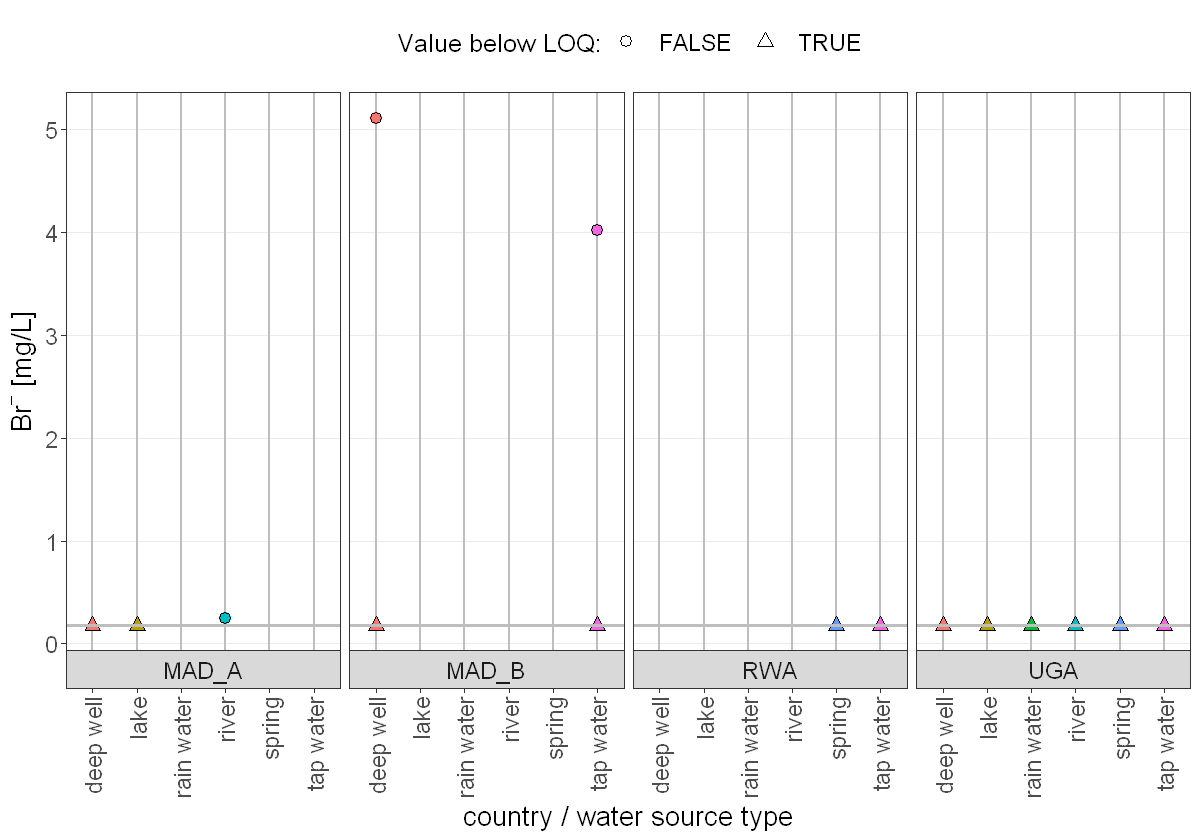

In [27]:
options(repr.plot.height=7,repr.plot.width=10)

feat <- "Br"
feat.loq <- df.lod$LOQ[df.lod$Column.name==feat]
feat.rec <- df.lod$Recommendation_top[df.lod$Column.name==feat]

p <- ggplot(df,aes(x=water.source.type,y=get(feat),fill=water.source.type)) + 
geom_point(size=3,aes(shape=get(paste0(feat,".LOQ")))) + 
geom_hline(yintercept = feat.loq,color="gray",linewidth=1) + 
geom_hline(yintercept = feat.rec,color="red",linewidth=1,linetype="dashed") + 
#scale_y_break(breaks=c(100,198),scales=c(0.1,2),ticklabels=c(200)) + ylim(0,201)+
scale_shape_manual(values=c(21, 24),name="Value below LOQ:")+
facet_wrap(~measurement.series,ncol=4,drop=TRUE,strip.position = "bottom") + 
xlab("country / water source type") + ylab(TeX("$Br^-$ [mg/L]"))+ 
guides(shape = "legend",colour="none",size="none",fill="none")+
theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1,size=14),
                   axis.text.y = element_text(size=14),
                   strip.text = element_text(size=14),
                   axis.title = element_text(size=16),
                   panel.grid.minor.y = element_blank(),
                   panel.grid.major.x = element_line(color = "gray",size = .75),
                   legend.position="top",
                   legend.key.size = unit(2, 'cm'), #change legend key size
                   legend.key.height = unit(1, 'cm'), #change legend key height
                   legend.key.width = unit(1, 'cm'), #change legend key width
                    legend.title = element_text(size=15), #change legend title font size
                   legend.text = element_text(size=14)) 

#ggsave("IMG/Br.tiff",p,width=10,height=7,dpi=300)
p

#### 7.11. $NO_3^-$

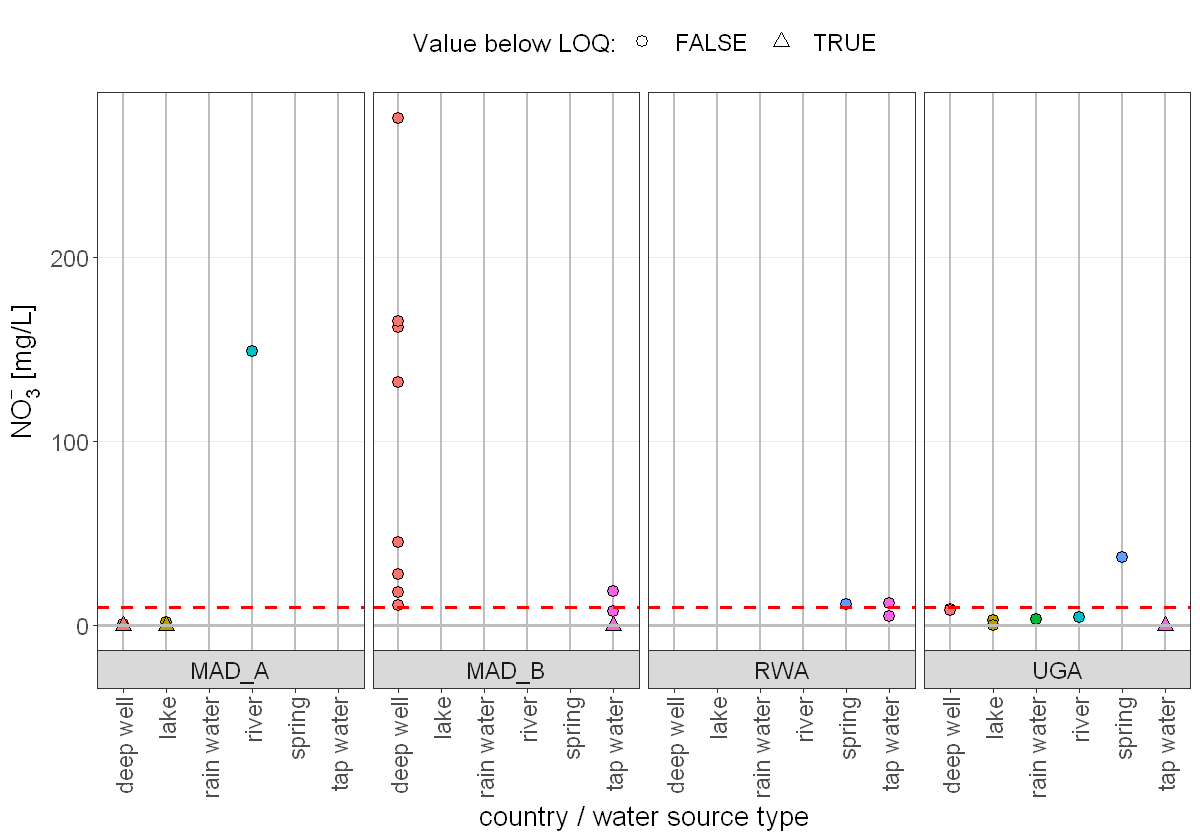

In [28]:
options(repr.plot.height=7,repr.plot.width=10)

feat <- "NO3"
feat.loq <- df.lod$LOQ[df.lod$Column.name==feat]
feat.rec <- df.lod$Recommendation_top[df.lod$Column.name==feat]

p <- ggplot(df,aes(x=water.source.type,y=get(feat),fill=water.source.type)) + 
geom_point(size=3,aes(shape=get(paste0(feat,".LOQ")))) + 
geom_hline(yintercept = feat.loq,color="gray",linewidth=1) + 
geom_hline(yintercept = feat.rec,color="red",linewidth=1,linetype="dashed") + 
#scale_y_break(breaks=c(100,198),scales=c(0.1,2),ticklabels=c(200)) + ylim(0,201)+
scale_shape_manual(values=c(21, 24),name="Value below LOQ:")+
facet_wrap(~measurement.series,ncol=4,drop=TRUE,strip.position = "bottom") + 
xlab("country / water source type") + ylab(TeX("$NO_3^-$ [mg/L]"))+ 
guides(shape = "legend",colour="none",size="none",fill="none")+
theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1,size=14),
                   axis.text.y = element_text(size=14),
                   strip.text = element_text(size=14),
                   axis.title = element_text(size=16),
                   panel.grid.minor.y = element_blank(),
                   panel.grid.major.x = element_line(color = "gray",size = .75),
                   legend.position="top",
                   legend.key.size = unit(2, 'cm'), #change legend key size
                   legend.key.height = unit(1, 'cm'), #change legend key height
                   legend.key.width = unit(1, 'cm'), #change legend key width
                    legend.title = element_text(size=15), #change legend title font size
                   legend.text = element_text(size=14)) 

#ggsave("IMG/NO3.tiff",p,width=10,height=7,dpi=300)
p

#### 7.12. $NO_2^-$

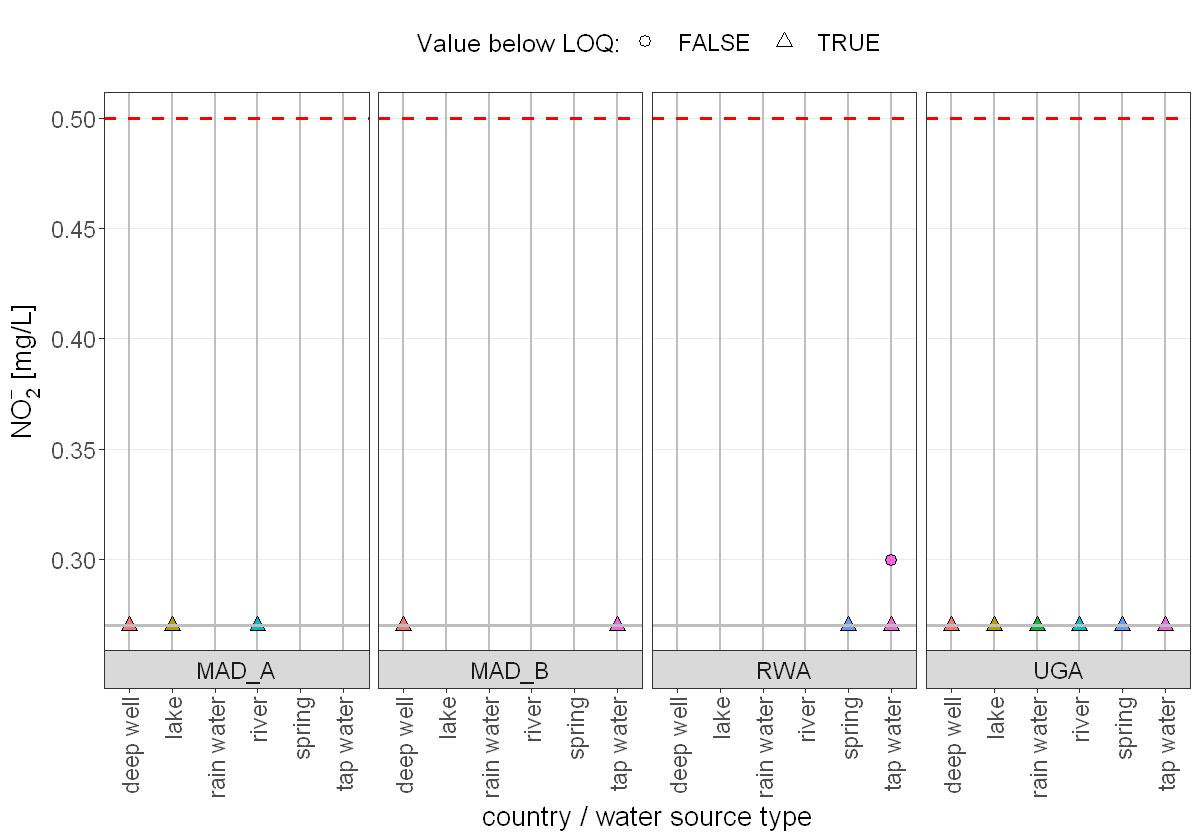

In [29]:
options(repr.plot.height=7,repr.plot.width=10)

feat <- "NO2"
feat.loq <- df.lod$LOQ[df.lod$Column.name==feat]
feat.rec <- df.lod$Recommendation_top[df.lod$Column.name==feat]

p <- ggplot(df,aes(x=water.source.type,y=get(feat),fill=water.source.type)) + 
geom_point(size=3,aes(shape=get(paste0(feat,".LOQ")))) + 
geom_hline(yintercept = feat.loq,color="gray",linewidth=1) + 
geom_hline(yintercept = feat.rec,color="red",linewidth=1,linetype="dashed") + 
#scale_y_break(breaks=c(0.31,0.49),scales=c(0.1,2),ticklabels=c(0.5)) + ylim(0,0.51)+
scale_shape_manual(values=c(21, 24),name="Value below LOQ:")+
facet_wrap(~measurement.series,ncol=4,drop=TRUE,strip.position = "bottom") + 
xlab("country / water source type") + ylab(TeX("$NO_2^-$ [mg/L]"))+ 
guides(shape = "legend",colour="none",size="none",fill="none")+
theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1,size=14),
                   axis.text.y = element_text(size=14),
                   strip.text = element_text(size=14),
                   axis.title = element_text(size=16),
                   panel.grid.minor.y = element_blank(),
                   panel.grid.major.x = element_line(color = "gray",size = .75),
                   legend.position="top",
                   legend.key.size = unit(2, 'cm'), #change legend key size
                   legend.key.height = unit(1, 'cm'), #change legend key height
                   legend.key.width = unit(1, 'cm'), #change legend key width
                    legend.title = element_text(size=15), #change legend title font size
                   legend.text = element_text(size=14)) 

#ggsave("IMG/NO2.tiff",p,width=10,height=7,dpi=300)
p

#### 7.13. $SO_4^{2-}$

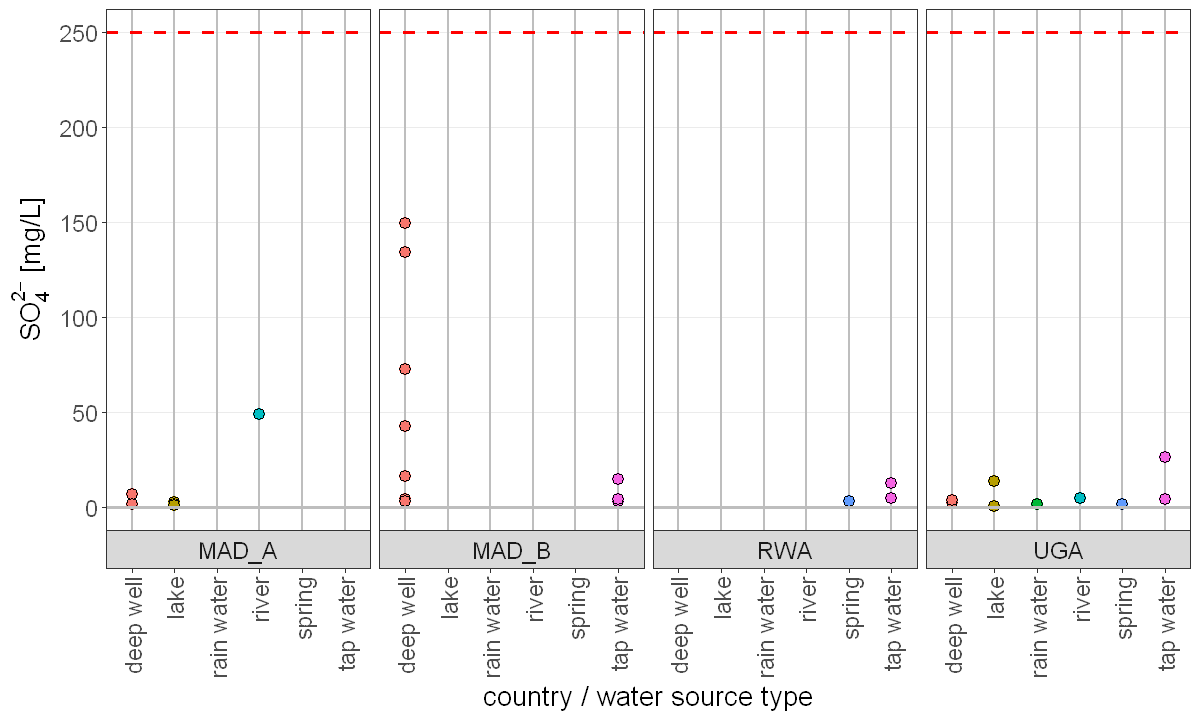

In [30]:
options(repr.plot.height=6,repr.plot.width=10)

feat <- "SO4"
feat.loq <- df.lod$LOQ[df.lod$Column.name==feat]
feat.rec <- df.lod$Recommendation_top[df.lod$Column.name==feat]

p <- ggplot(df,aes(x=water.source.type,y=get(feat),fill=water.source.type)) + 
geom_point(size=3,aes(shape=get(paste0(feat,".LOQ")))) + 
geom_hline(yintercept = feat.loq,color="gray",linewidth=1) + 
geom_hline(yintercept = feat.rec,color="red",linewidth=1,linetype="dashed") + 

#scale_y_break(breaks=c(100,198),scales=c(0.1,2),ticklabels=c(200)) + ylim(0,201)+

scale_shape_manual(values=c(21, 24),name="Value below LOQ:")+
facet_wrap(~measurement.series,ncol=4,drop=TRUE,strip.position = "bottom") + 
xlab("country / water source type") + ylab(TeX("$SO_4^{2-}$ [mg/L]"))+ 
guides(shape = "legend",colour="none",size="none",fill="none")+
theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1,size=14),
                   axis.text.y = element_text(size=14),
                   strip.text = element_text(size=14),
                   axis.title = element_text(size=16),
                   panel.grid.minor.y = element_blank(),
                   panel.grid.major.x = element_line(color = "gray",size = .75),
                   legend.position="none",
                   legend.key.size = unit(2, 'cm'), #change legend key size
                   legend.key.height = unit(1, 'cm'), #change legend key height
                   legend.key.width = unit(1, 'cm'), #change legend key width
                    legend.title = element_text(size=15), #change legend title font size
                   legend.text = element_text(size=14)) 

#ggsave("IMG/SO4.tiff",p,width=10,height=6,dpi=300)
p

#### 7.14. $PO_4^{3-}$

Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_hline()`)."


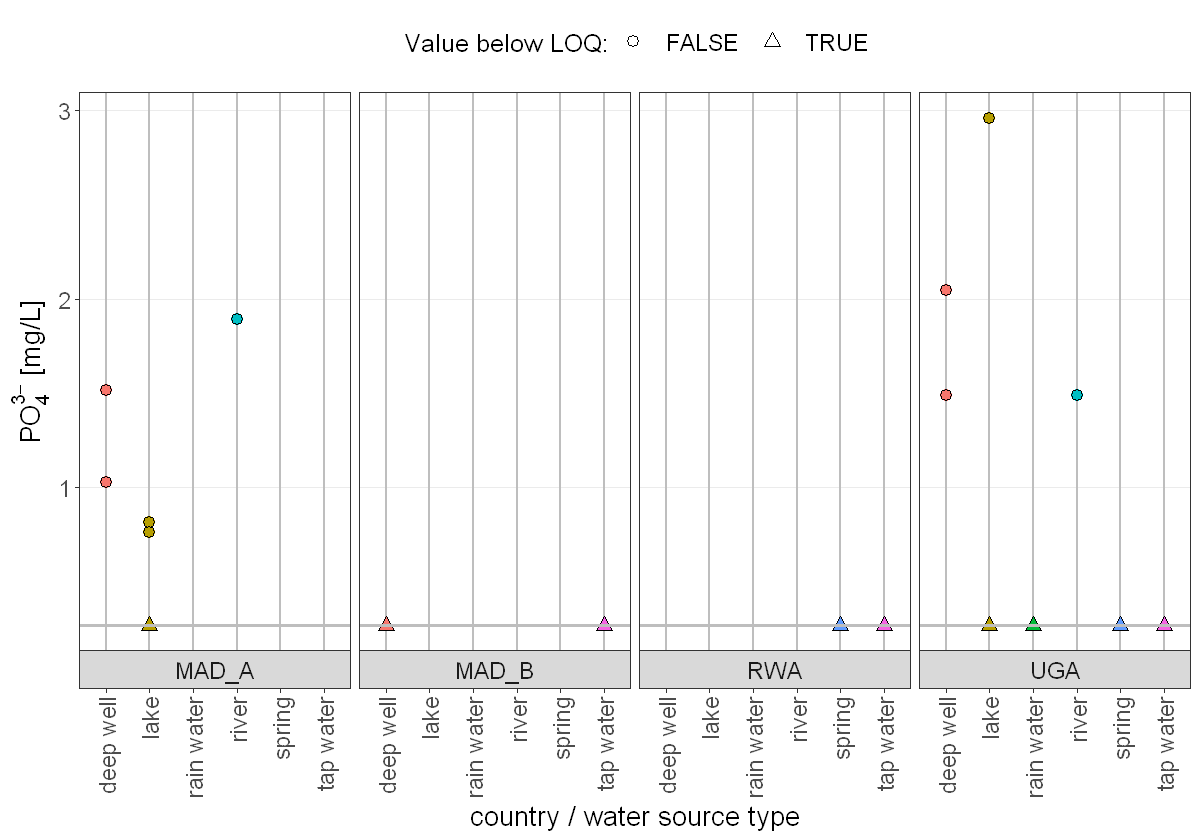

In [31]:
options(repr.plot.height=7,repr.plot.width=10)

feat <- "PO4"
feat.loq <- df.lod$LOQ[df.lod$Column.name==feat]
feat.rec <- df.lod$Recommendation_top[df.lod$Column.name==feat]

p <- ggplot(df,aes(x=water.source.type,y=get(feat),fill=water.source.type)) + 
geom_point(size=3,aes(shape=get(paste0(feat,".LOQ")))) + 
geom_hline(yintercept = feat.loq,color="gray",linewidth=1) + 
geom_hline(yintercept = feat.rec,color="red",linewidth=1,linetype="dashed") + 

#scale_y_break(breaks=c(100,198),scales=c(0.1,2),ticklabels=c(200)) + ylim(0,201)+

scale_shape_manual(values=c(21, 24),name="Value below LOQ:")+
facet_wrap(~measurement.series,ncol=4,drop=TRUE,strip.position = "bottom") + 
xlab("country / water source type") + ylab(TeX("$PO_4^{3-}$ [mg/L]"))+ 
guides(shape = "legend",colour="none",size="none",fill="none")+
theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1,size=14),
                   axis.text.y = element_text(size=14),
                   strip.text = element_text(size=14),
                   axis.title = element_text(size=16),
                   panel.grid.minor.y = element_blank(),
                   panel.grid.major.x = element_line(color = "gray",size = .75),
                   legend.position="top",
                   legend.key.size = unit(2, 'cm'), #change legend key size
                   legend.key.height = unit(1, 'cm'), #change legend key height
                   legend.key.width = unit(1, 'cm'), #change legend key width
                    legend.title = element_text(size=15), #change legend title font size
                   legend.text = element_text(size=14)) 

#ggsave("IMG/PO4.tiff",p,width=10,height=7,dpi=300)
p

#### 7.15. $Li^+$

Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_hline()`)."


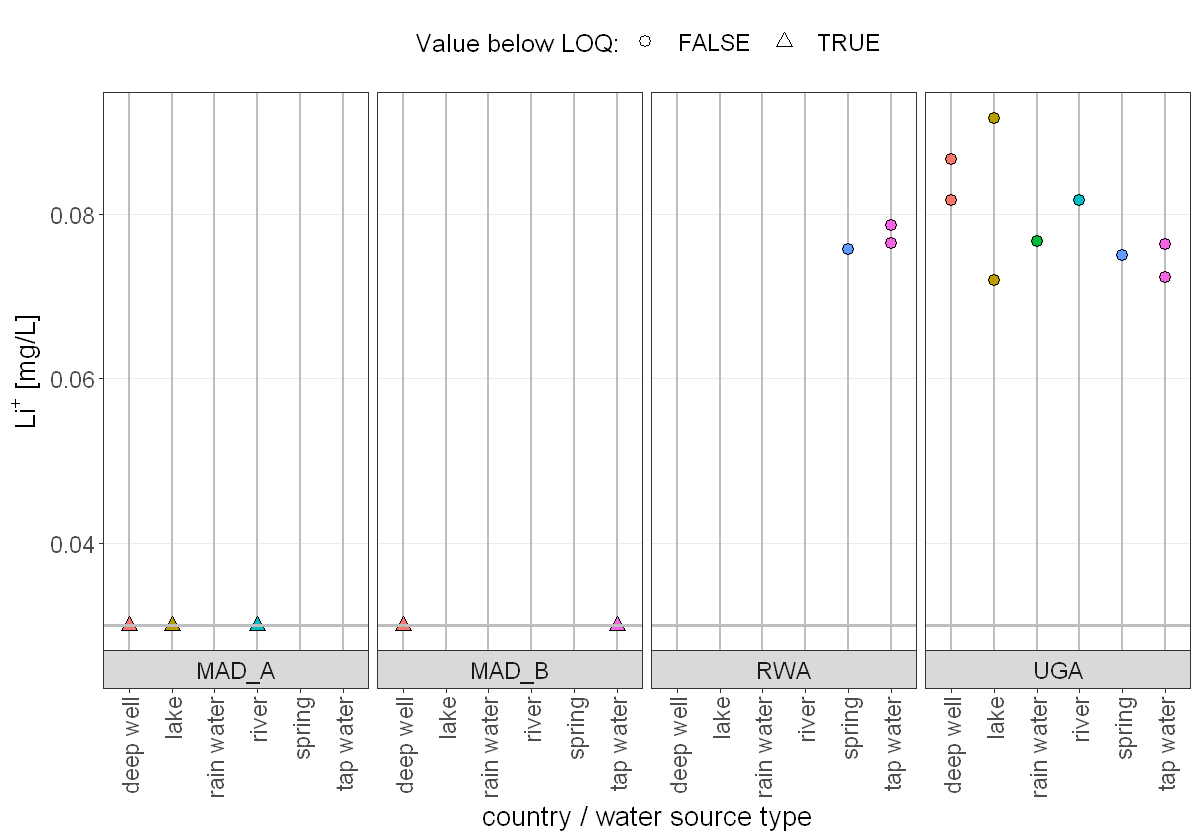

In [32]:
options(repr.plot.height=7,repr.plot.width=10)

feat <- "Li"
feat.loq <- df.lod$LOQ[df.lod$Column.name==feat]
feat.rec <- df.lod$Recommendation_top[df.lod$Column.name==feat]

p <- ggplot(df,aes(x=water.source.type,y=get(feat),fill=water.source.type)) + 
geom_point(size=3,aes(shape=get(paste0(feat,".LOQ")))) + 
geom_hline(yintercept = feat.loq,color="gray",linewidth=1) + 
geom_hline(yintercept = feat.rec,color="red",linewidth=1,linetype="dashed") + 

#scale_y_break(breaks=c(100,198),scales=c(0.1,2),ticklabels=c(200)) + ylim(0,201)+

scale_shape_manual(values=c(21, 24),name="Value below LOQ:")+
facet_wrap(~measurement.series,ncol=4,drop=TRUE,strip.position = "bottom") + 
xlab("country / water source type") + ylab(TeX("$Li^+$ [mg/L]"))+ 
guides(shape = "legend",colour="none",size="none",fill="none")+
theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1,size=14),
                   axis.text.y = element_text(size=14),
                   strip.text = element_text(size=14),
                   axis.title = element_text(size=16),
                   panel.grid.minor.y = element_blank(),
                   panel.grid.major.x = element_line(color = "gray",size = .75),
                   legend.position="top",
                   legend.key.size = unit(2, 'cm'), #change legend key size
                   legend.key.height = unit(1, 'cm'), #change legend key height
                   legend.key.width = unit(1, 'cm'), #change legend key width
                    legend.title = element_text(size=15), #change legend title font size
                   legend.text = element_text(size=14)) 

#ggsave("IMG/Li.tiff",p,width=10,height=7,dpi=300)
p

#### 7.16. $Na^+$

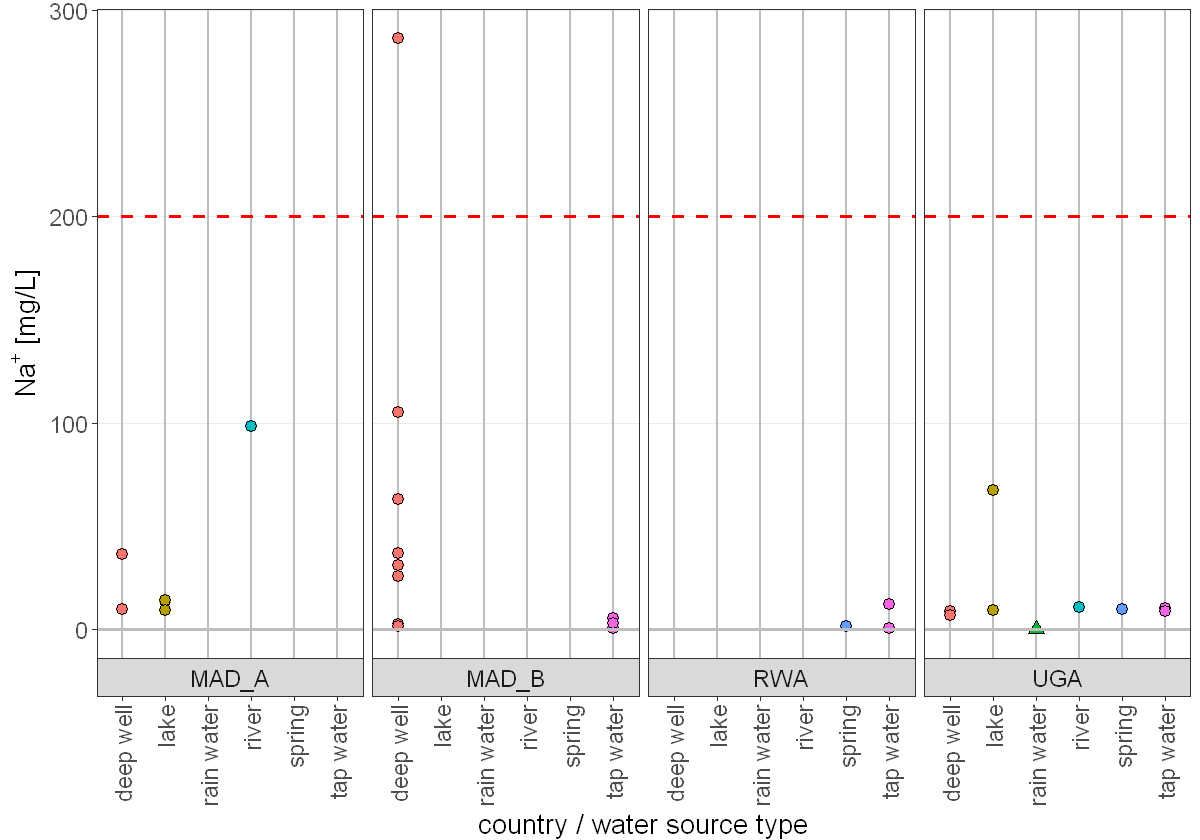

In [33]:
options(repr.plot.height=7,repr.plot.width=10)

feat <- "Na"
feat.loq <- df.lod$LOQ[df.lod$Column.name==feat]
feat.rec <- df.lod$Recommendation_top[df.lod$Column.name==feat]

p <- ggplot(df,aes(x=water.source.type,y=get(feat),fill=water.source.type)) + 
geom_point(size=3,aes(shape=get(paste0(feat,".LOQ")))) + 
geom_hline(yintercept = feat.loq,color="gray",linewidth=1) + 
geom_hline(yintercept = feat.rec,color="red",linewidth=1,linetype="dashed") + 

#scale_y_break(breaks=c(100,198),scales=c(0.1,2),ticklabels=c(200)) + ylim(0,201)+

scale_shape_manual(values=c(21, 24),name="Value below LOQ:")+
facet_wrap(~measurement.series,ncol=4,drop=TRUE,strip.position = "bottom") + 
xlab("country / water source type") + ylab(TeX("$Na^+$ [mg/L]"))+ 
guides(shape = "legend",colour="none",size="none",fill="none")+
theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1,size=14),
                   axis.text.y = element_text(size=14),
                   strip.text = element_text(size=14),
                   axis.title = element_text(size=16),
                   panel.grid.minor.y = element_blank(),
                   panel.grid.major.x = element_line(color = "gray",size = .75),
                   legend.position="btop",
                   legend.key.size = unit(2, 'cm'), #change legend key size
                   legend.key.height = unit(1, 'cm'), #change legend key height
                   legend.key.width = unit(1, 'cm'), #change legend key width
                    legend.title = element_text(size=15), #change legend title font size
                   legend.text = element_text(size=14)) 

#ggsave("IMG/Na.tiff",p,width=10,height=7,dpi=300)
p

#### 7.17. $K^+$

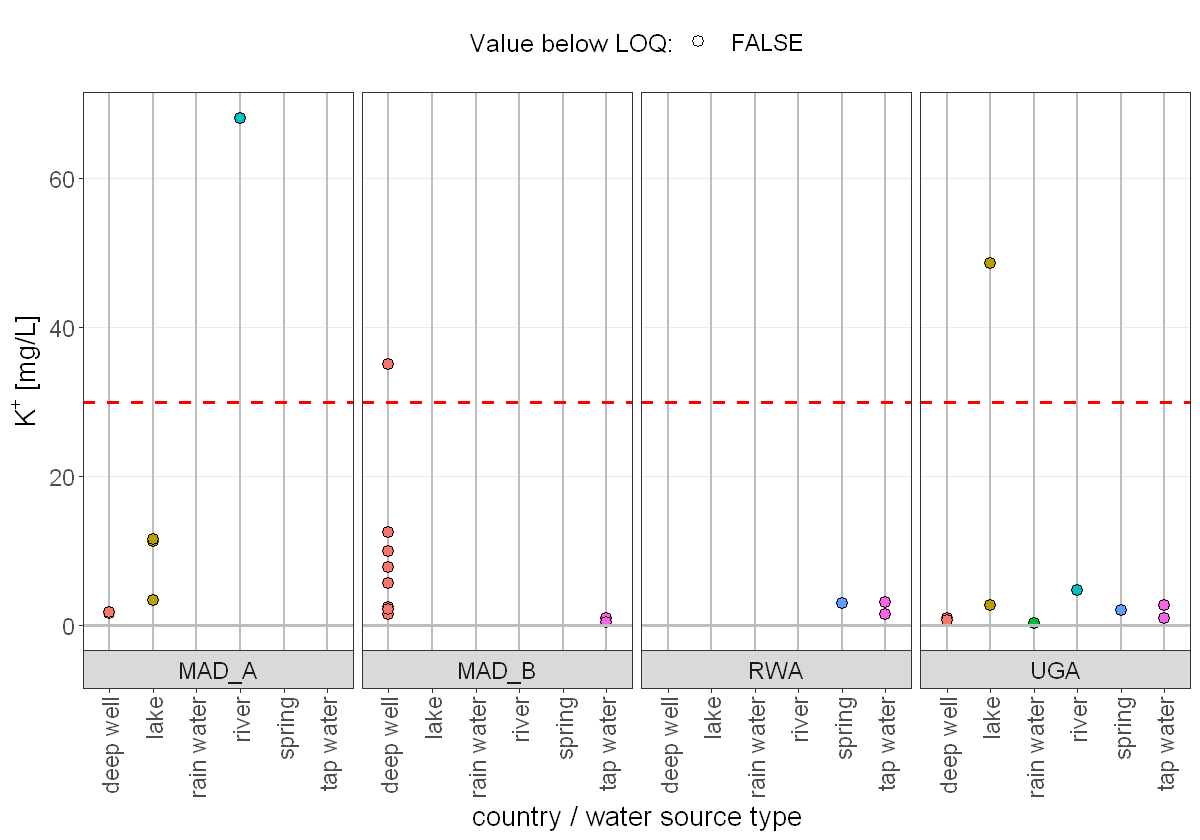

In [34]:
options(repr.plot.height=7,repr.plot.width=10)

feat <- "K"
feat.loq <- df.lod$LOQ[df.lod$Column.name==feat]
feat.rec <- df.lod$Recommendation_top[df.lod$Column.name==feat]

p <- ggplot(df,aes(x=water.source.type,y=get(feat),fill=water.source.type)) + 
geom_point(size=3,aes(shape=get(paste0(feat,".LOQ")))) + 
geom_hline(yintercept = feat.loq,color="gray",linewidth=1) + 
geom_hline(yintercept = feat.rec,color="red",linewidth=1,linetype="dashed") + 

#scale_y_break(breaks=c(100,198),scales=c(0.1,2),ticklabels=c(200)) + ylim(0,201)+

scale_shape_manual(values=c(21, 24),name="Value below LOQ:")+
facet_wrap(~measurement.series,ncol=4,drop=TRUE,strip.position = "bottom") + 
xlab("country / water source type") + ylab(TeX("$K^+$ [mg/L]"))+ 
guides(shape = "legend",colour="none",size="none",fill="none")+
theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1,size=14),
                   axis.text.y = element_text(size=14),
                   strip.text = element_text(size=14),
                   axis.title = element_text(size=16),
                   panel.grid.minor.y = element_blank(),
                   panel.grid.major.x = element_line(color = "gray",size = .75),
                   legend.position="top",
                   legend.key.size = unit(2, 'cm'), #change legend key size
                   legend.key.height = unit(1, 'cm'), #change legend key height
                   legend.key.width = unit(1, 'cm'), #change legend key width
                    legend.title = element_text(size=15), #change legend title font size
                   legend.text = element_text(size=14)) 

#ggsave("IMG/K.tiff",p,width=10,height=7,dpi=300)
p

#### 7.18. $NH_4^+$

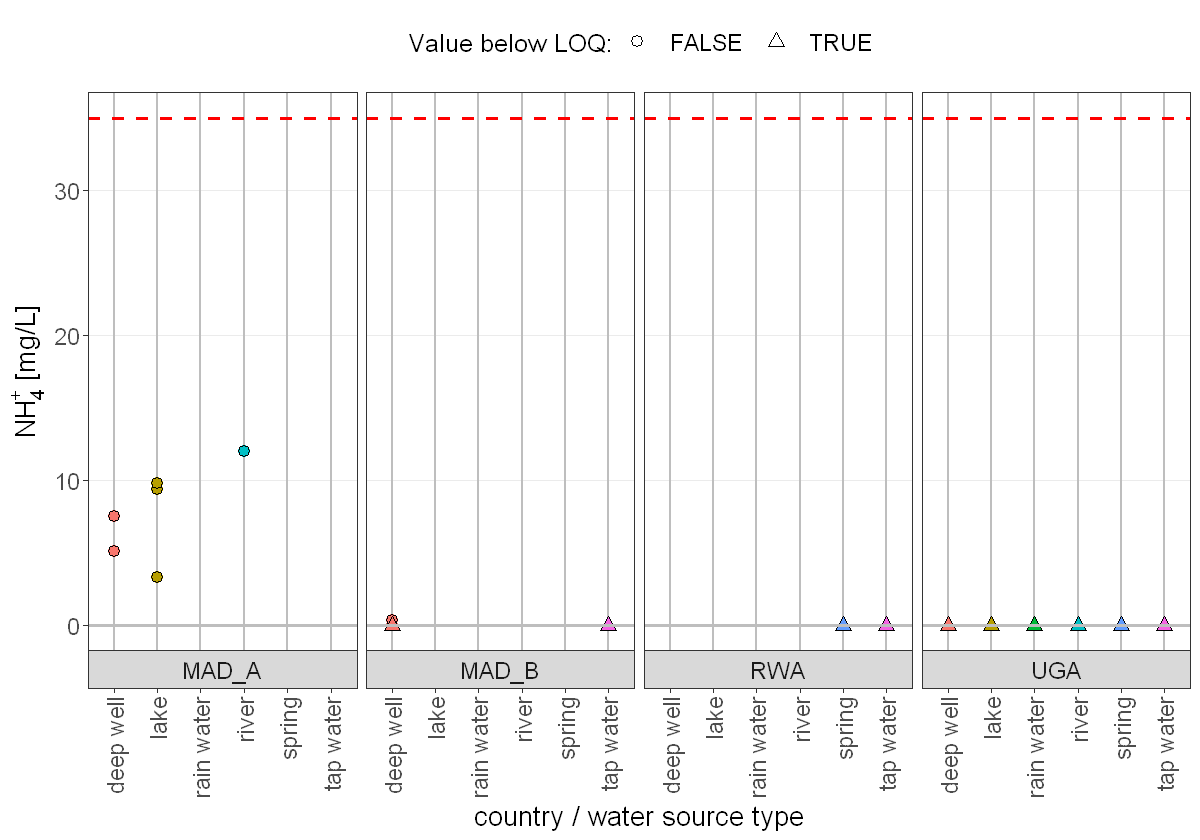

In [35]:
options(repr.plot.height=7,repr.plot.width=10)

feat <- "NH4"
feat.loq <- df.lod$LOQ[df.lod$Column.name==feat]
feat.rec <- df.lod$Recommendation_top[df.lod$Column.name==feat]

p <- ggplot(df,aes(x=water.source.type,y=get(feat),fill=water.source.type)) + 
geom_point(size=3,aes(shape=get(paste0(feat,".LOQ")))) + 
geom_hline(yintercept = feat.loq,color="gray",linewidth=1) + 
geom_hline(yintercept = feat.rec,color="red",linewidth=1,linetype="dashed") + 

#scale_y_break(breaks=c(100,198),scales=c(0.1,2),ticklabels=c(200)) + ylim(0,201)+

scale_shape_manual(values=c(21, 24),name="Value below LOQ:")+
facet_wrap(~measurement.series,ncol=4,drop=TRUE,strip.position = "bottom") + 
xlab("country / water source type") + ylab(TeX("$NH_4^+$ [mg/L]"))+ 
guides(shape = "legend",colour="none",size="none",fill="none")+
theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1,size=14),
                   axis.text.y = element_text(size=14),
                   strip.text = element_text(size=14),
                   axis.title = element_text(size=16),
                   panel.grid.minor.y = element_blank(),
                   panel.grid.major.x = element_line(color = "gray",size = .75),
                   legend.position="top",
                   legend.key.size = unit(2, 'cm'), #change legend key size
                   legend.key.height = unit(1, 'cm'), #change legend key height
                   legend.key.width = unit(1, 'cm'), #change legend key width
                    legend.title = element_text(size=15), #change legend title font size
                   legend.text = element_text(size=14)) 

#ggsave("IMG/NH4.tiff",p,width=10,height=7,dpi=300)
p

#### 7.19. $Ca_2^+$

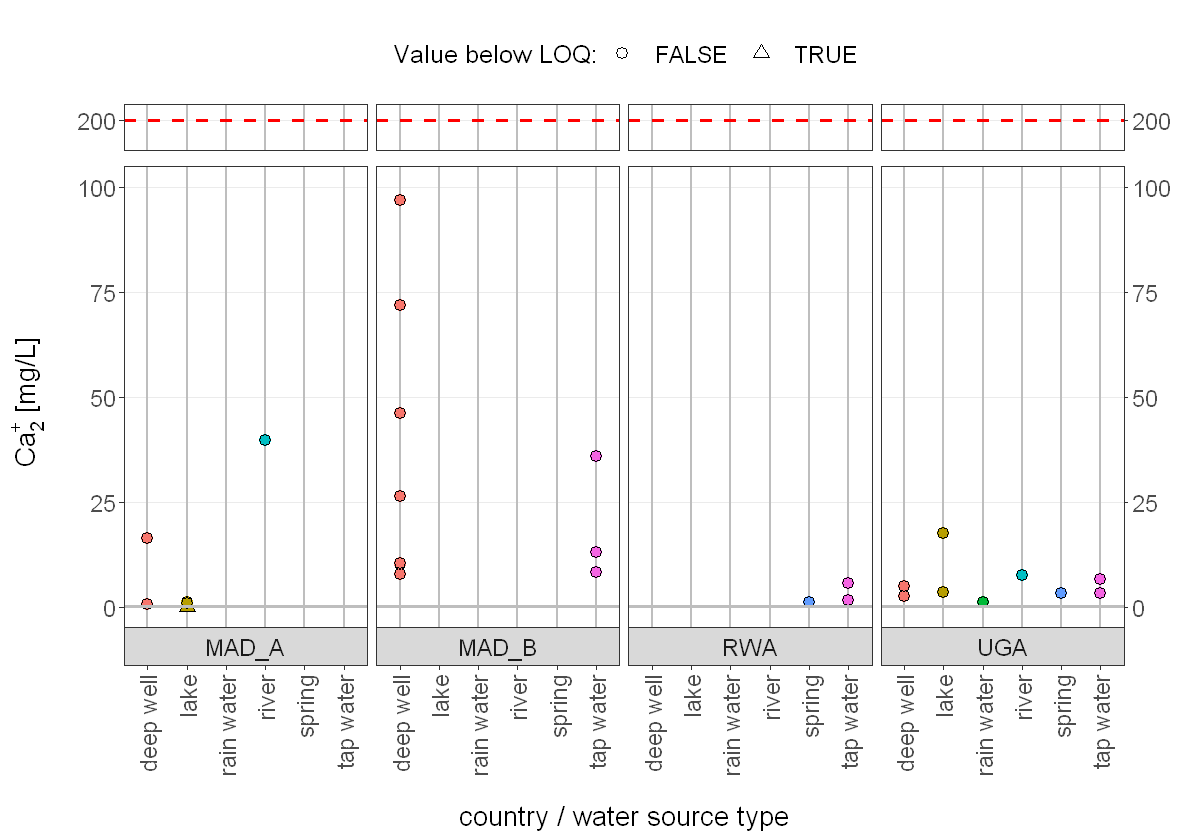

In [36]:
options(repr.plot.height=7,repr.plot.width=10)

feat <- "Ca2"
feat.loq <- df.lod$LOQ[df.lod$Column.name==feat]
feat.rec <- df.lod$Recommendation_top[df.lod$Column.name==feat]

p <- ggplot(df,aes(x=water.source.type,y=get(feat),fill=water.source.type)) + 
geom_point(size=3,aes(shape=get(paste0(feat,".LOQ")))) + 
geom_hline(yintercept = feat.loq,color="gray",linewidth=1) + 
geom_hline(yintercept = feat.rec,color="red",linewidth=1,linetype="dashed") + 
scale_y_break(breaks=c(100,198),scales=c(0.1,2),ticklabels=c(200)) + ylim(0,201)+
scale_shape_manual(values=c(21, 24),name="Value below LOQ:")+
facet_wrap(~measurement.series,ncol=4,drop=TRUE,strip.position = "bottom") + 
xlab("country / water source type") + ylab(TeX("$Ca_2^+$ [mg/L]"))+ 
guides(shape = "legend",colour="none",size="none",fill="none")+
theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1,size=14),
                   axis.text.y = element_text(size=14),
                   strip.text = element_text(size=14),
                   axis.title = element_text(size=16),
                   panel.grid.minor.y = element_blank(),
                   panel.grid.major.x = element_line(color = "gray",size = .75),
                   legend.position="top",
                   legend.key.size = unit(2, 'cm'), #change legend key size
                   legend.key.height = unit(1, 'cm'), #change legend key height
                   legend.key.width = unit(1, 'cm'), #change legend key width
                    legend.title = element_text(size=15), #change legend title font size
                   legend.text = element_text(size=14)) 

#ggsave("IMG/Ca2.tiff",p,width=10,height=7,dpi=300)
p

#### 7.20. $Mg^{2+}$

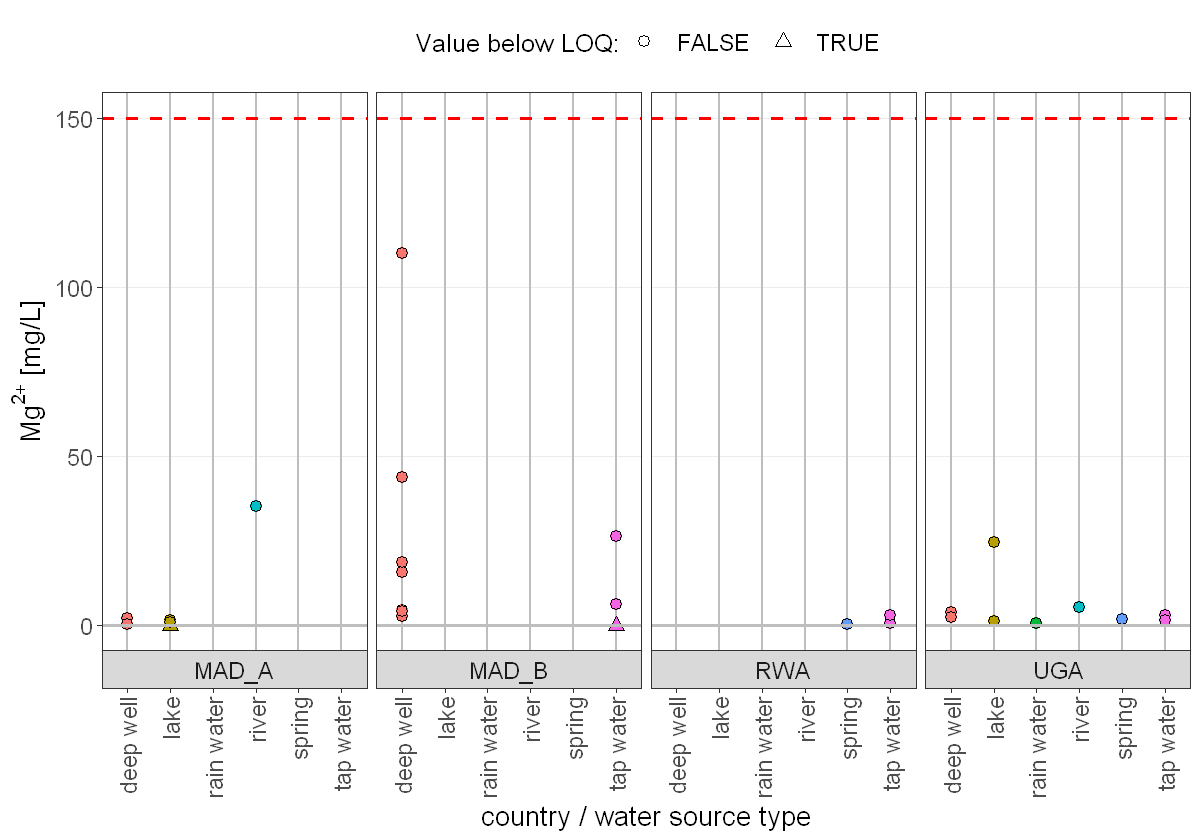

In [37]:
options(repr.plot.height=7,repr.plot.width=10)

feat <- "Mg2"
feat.loq <- df.lod$LOQ[df.lod$Column.name==feat]
feat.rec <- df.lod$Recommendation_top[df.lod$Column.name==feat]

p <- ggplot(df,aes(x=water.source.type,y=get(feat),fill=water.source.type)) + 
geom_point(size=3,aes(shape=get(paste0(feat,".LOQ")))) + 
geom_hline(yintercept = feat.loq,color="gray",linewidth=1) + 
geom_hline(yintercept = feat.rec,color="red",linewidth=1,linetype="dashed") + 

#scale_y_break(breaks=c(100,198),scales=c(0.1,2),ticklabels=c(200)) + ylim(0,201)+

scale_shape_manual(values=c(21, 24),name="Value below LOQ:")+
facet_wrap(~measurement.series,ncol=4,drop=TRUE,strip.position = "bottom") + 
xlab("country / water source type") + ylab(TeX("$Mg^{2+}$ [mg/L]"))+ 
guides(shape = "legend",colour="none",size="none",fill="none")+
theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1,size=14),
                   axis.text.y = element_text(size=14),
                   strip.text = element_text(size=14),
                   axis.title = element_text(size=16),
                   panel.grid.minor.y = element_blank(),
                   panel.grid.major.x = element_line(color = "gray",size = .75),
                   legend.position="top",
                   legend.key.size = unit(2, 'cm'), #change legend key size
                   legend.key.height = unit(1, 'cm'), #change legend key height
                   legend.key.width = unit(1, 'cm'), #change legend key width
                    legend.title = element_text(size=15), #change legend title font size
                   legend.text = element_text(size=14)) 

#ggsave("IMG/Mg2.tiff",p,width=10,height=7,dpi=300)
p

Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_hline()`)."


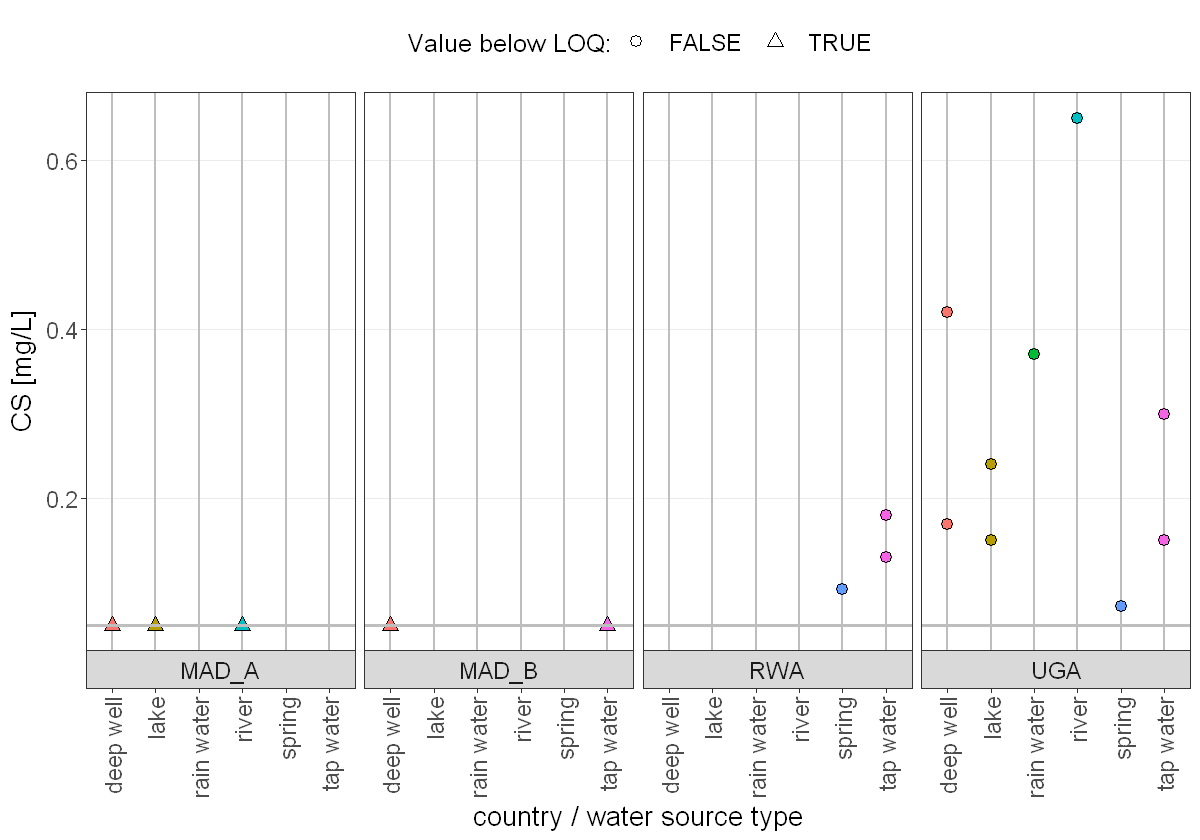

In [38]:
options(repr.plot.height=7,repr.plot.width=10)

feat <- "CS"
feat.loq <- df.lod$LOQ[df.lod$Column.name==feat]
feat.rec <- df.lod$Recommendation_top[df.lod$Column.name==feat]

p <- ggplot(df,aes(x=water.source.type,y=get(feat),fill=water.source.type)) + 
geom_point(size=3,aes(shape=get(paste0(feat,".LOQ")))) + 
geom_hline(yintercept = feat.loq,color="gray",linewidth=1) + 
geom_hline(yintercept = feat.rec,color="red",linewidth=1,linetype="dashed") + 

#scale_y_break(breaks=c(100,198),scales=c(0.1,2),ticklabels=c(200)) + ylim(0,201)+

scale_shape_manual(values=c(21, 24),name="Value below LOQ:")+
facet_wrap(~measurement.series,ncol=4,drop=TRUE,strip.position = "bottom") + 
xlab("country / water source type") + ylab(TeX("$CS$ [mg/L]"))+ 
guides(shape = "legend",colour="none",size="none",fill="none")+
theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1,size=14),
                   axis.text.y = element_text(size=14),
                   strip.text = element_text(size=14),
                   axis.title = element_text(size=16),
                   panel.grid.minor.y = element_blank(),
                   panel.grid.major.x = element_line(color = "gray",size = .75),
                   legend.position="top",
                   legend.key.size = unit(2, 'cm'), #change legend key size
                   legend.key.height = unit(1, 'cm'), #change legend key height
                   legend.key.width = unit(1, 'cm'), #change legend key width
                    legend.title = element_text(size=15), #change legend title font size
                   legend.text = element_text(size=14)) 

#ggsave("IMG/CS.tiff",p,width=10,height=7,dpi=300)
p